# Итоговая проектная работа

# Часть 1: Банки - анализ оттока клиентов

## Презентация

https://disk.yandex.ru/i/GuADCmbVbUVEvQ

## Задача

Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.<br>

1. Провеcти исследовательский анализ данных, определить все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка и т.д)
2. Сформулировать и проверить статистические гипотезы:
    - проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
    - сформулировать и проверить статистическую гипотезу относительно представленных данных, которая поможет внести ясность в исследование. 
3. Объединяя признаки отточности, сформировать сегменты, отобрать из них лучшие и дать по ним рекомендации.

## Заказчик

Отдел маркетинга банка.

## Контекст

Для исследования предоставлен датасет, который содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. 

## Ретроспектива

Ранее было проведено исследование оттока, но клиентская база поменялась и текущие решения не работают.

## Декомпозиция задачи

### Определение проблемы и постановка целей

- **Описание проблемы:** понятие оттока - клиенты закрывают счета или перестают пользоваться услугами банка.<br>
- **Цель анализа:** выявить ключевые факторы оттока. 

### Сбор и подготовка данных

- **Описание датасета:**<br>

| **Колонка**     | **Описание**                                          |
|:----------------|:------------------------------------------------------|
| `userid`        | Идентификатор пользователя                             |
| `score`         | Баллы кредитного скоринга                              |
| `city`          | Город                                                  |
| `gender`        | Пол                                                    |
| `age`           | Возраст                                                |
| `equity`        | Количество баллов собственности                        |
| `balance`       | Баланс на счёте                                        |
| `products`      | Количество продуктов, которыми пользуется клиент       |
| `credit_card`   | Есть ли кредитная карта                                |
| `last_activity` | Активный клиент (да/нет)                               |
| `est_salary`    | Оценочный доход клиента                                |
| `churn`         | Признак оттока (да/нет)                                |
<br><br>

- **Предобработка данных:** автоматическая обработка датасета с помощью универсальных собственных функций (приведение заголовков к единому стилю, удаление явных дубликатов, подсчёт доли пропущенных значений.<br>
- **Ручная очистка данных:** проверка  на соответствие типов данных, поиск неявных дубликатов, анализ пропущенных значений, поиск выбросов и аномальных значений.

### Анализ данных

- **Исследовательский анализ:** изучение структуры данных, выявление основных закономерностей, взаимосвязей, поиск отточных интервалов. Построение графиков и диаграмм для визуализации результатов.<br>
- **Корреляционный анализ:** изучение корреляций в данных, интерпретация результатов.<br>
- **Статистический анализ:** проведение статистических тестов, для определения значимости различных факторов, которые могут влиять на отток клиентов.<br>
- **Сегментация:** определение групп клиентов с похожими характеристиками, выявление сегментов наиболее склонных к оттоку, анализ отточных клиентов в разрезе различных характеристик, приоритизация сегментов.<br>

### Разработка рекомендаций

- **Рекомендации по удержанию клиентов:** предложение конкретных мер на основе результатов анализа, которые помогут снизить отток.

### Оформление и представление результатов

- **Подготовка отчёта:** оформление всех этапов работы в виде структурированного отчёта, включая введение, описание данных, результаты анализа, выводы и рекомендации.<br>
- **Презентация результатов:** подготовка презентации с ключевыми выводами и рекомендациями для заказчика.

## Загрузка данных

In [1]:
import re
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from phik import resources
from scipy import stats as st
from sqlalchemy import text, create_engine
from phik.report import plot_correlation_matrix
from scipy.stats import chi2_contingency, fisher_exact

In [2]:
df = pd.read_csv('D:\\ds\\bank_scrooge.csv')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 200)

## Предобработка

In [3]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def prep(dataframe):
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    return dataframe

def get_info(dataframe):
    display(dataframe.head(5))
    print('*'*50)
    dataframe.info()
    print('*'*50)
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print('*'*39)
    print('Пропусков в колонках:')
    missing_counts = dataframe.isna().sum()
    percentage_missing = (missing_counts / dataframe.shape[0]) * 100
    print(pd.concat([missing_counts, percentage_missing.round(1)], 
                    axis=1, keys=['Количество', 'Доля, %']))

def get_uniques(dataframe):
    columns = dataframe.columns
    uniques = [dataframe[col].dropna().unique().tolist() for col in columns]
    data_types = [dataframe[col].dtype for col in columns]
    result_df = pd.DataFrame(
        {'Столбцы': columns,
         'Уникальные значения': uniques, 
         'Тип данных': data_types})
    return result_df

### Обработка с помощью функций и общая информация

In [4]:
df = prep(df)
get_info(df)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
**************************************************
Явных дубликатов: 0
***************************************
Пропусков в колонках:
               Количество  Д

Пропуски присутствуют в двух столбцах. Незначительное количество в возрасте и почти четверть пропущенных значений в данных о балансе клиента.

### Обработка пропусков

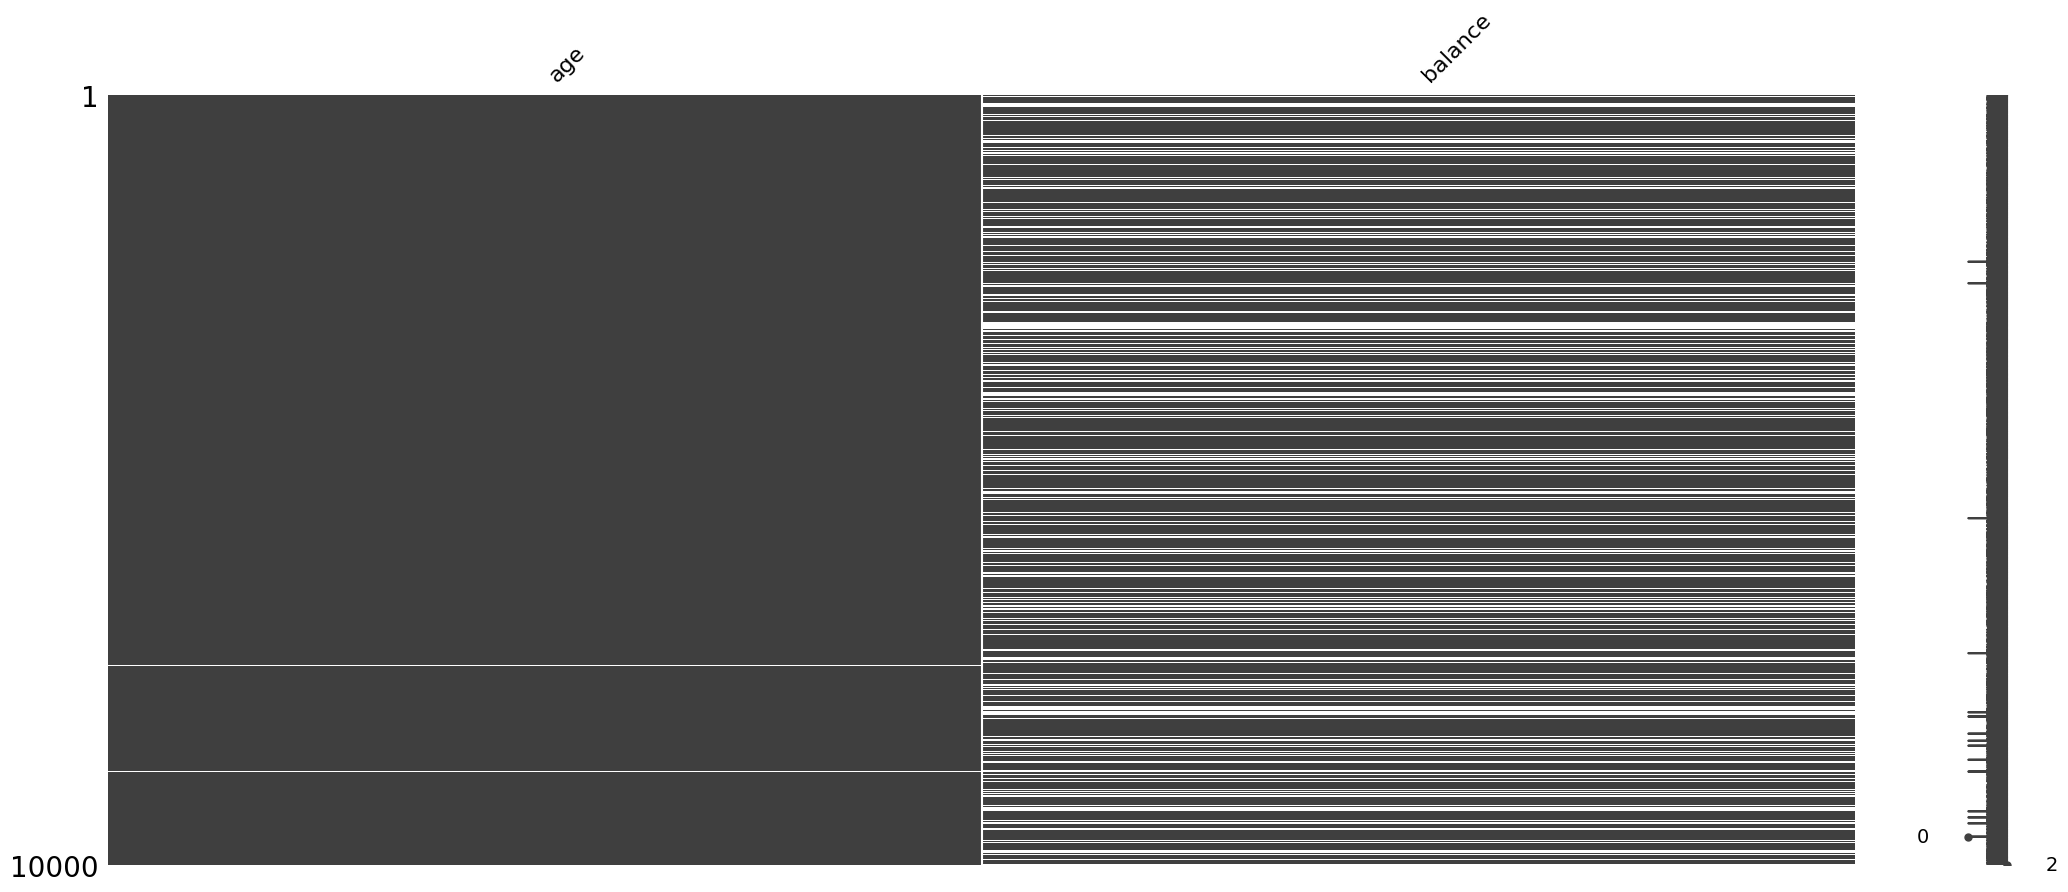

In [5]:
df_subset = df[['age', 'balance']]
msno.matrix(df_subset)
plt.show()

На первый взгляд распределение пропусков в balance равномерное и бессистемное. Попробую выловить зависимость пропусков в balance от других признаков, проанализировав средние значения по группам. Для этого я создам два новых столбца (age_na и balance_na), где 0 и 1 отмечу отсутствие либо наличие значения в соответствующей колонке. Далее я посчитаю средние значения других признаков в разрезе групп с пропусками и без пропусков. Если окажется, что средние значения для некоторых признаков значительно отличаются между группами, это может указывать на то, что пропуски в balance не случайны и могут зависеть от других характеристик клиента.

In [6]:
df['age_na'] = df['age'].isnull().astype(int)
df['balance_na'] = df['balance'].isnull().astype(int)
age_na_sum = df.groupby('age_na').mean().round(2)
balance_na_sum = df.groupby('balance_na').mean().round(2)
city_mode = df.groupby('age_na')['city'].agg(
    pd.Series.mode).rename('city_mode')
gender_mode = df.groupby('age_na')['gender'].agg(
    pd.Series.mode).rename('gender_mode')
age_na_sum = age_na_sum.join(city_mode)
age_na_sum = age_na_sum.join(gender_mode)
city_mode = df.groupby('balance_na')['city'].agg(
    pd.Series.mode).rename('city_mode')
gender_mode = df.groupby('balance_na')['gender'].agg(
    pd.Series.mode).rename('gender_mode')
balance_na_sum = balance_na_sum.join(city_mode)
balance_na_sum = balance_na_sum.join(gender_mode)
print("Средние значения по группам age_na:")
display(age_na_sum)
print()
print("Средние значения по группам balance_na:")
display(balance_na_sum)

Средние значения по группам age_na:


,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_na,city_mode,gender_mode
age_na,,,,,,,,,,,,,
0,171755.22,848.68,42.73,2.63,827245.59,1.87,0.68,0.52,147786.81,0.18,0.23,Ярославль,М
1,194637.50,855.15,NaN,1.38,1250033.57,1.35,0.77,0.77,178585.20,0.04,0.62,Ярославль,М



Средние значения по группам balance_na:


,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,city_mode,gender_mode
balance_na,,,,,,,,,,,,,
0,171738.84,843.74,42.92,3.40,827794.31,2.08,0.64,0.52,124501.87,0.23,0.00,Ярославль,Ж
1,172069.45,865.35,42.09,0.05,NaN,1.16,0.82,0.55,226310.21,0.01,0.01,Ярославль,М


Пропуски в столбце с возрастом незначительны, поэтому проанализирую только показатели в группах по балансу.<br><br>
1. **Активы:**
   - Средний объем активов для клиентов с известным балансом (3.40) значительно выше, чем для клиентов с пропущенным балансом (0.05).

2. **Оценка и зарплата:**
   - Средний балл у клиентов с известным балансом (843.74) ниже, чем у клиентов с пропущенным балансом (865.35).
   - Оценочная зарплата выше у клиентов с пропущенным балансом (226,310.21) по сравнению с клиентами с известным балансом (124,501.87).

3. **Отток:**
   - Средний уровень оттока у клиентов с пропущенным балансом (1%) значительно ниже, чем у клиентов с известным балансом (23%).
   
<br>   
Данный метод анализа подтверждает предположение о том, что пропуски являются бессистемными, т.к. повышенные взаимосвязаные показатели по балансу, рейтингу, активам и доходу распределены по обеим группам. Для того, чтоб окончательно убедиться в предположении, воспользуюсь методом корреляций.

In [7]:
correlations = df.corr()
correlations_na = correlations[['age_na', 'balance_na']]
correlations_na

,age_na,balance_na
userid,0.034571,0.004125
score,0.005035,0.138871
age,NaN,-0.028659
equity,-0.032040,-0.709951
balance,0.007686,NaN
products,-0.033751,-0.487512
credit_card,0.009726,0.158334
last_activity,0.025120,0.028362
est_salary,0.011252,0.307154
churn,-0.018994,-0.249421


Наиболее сильная положительная корреляция составляет 0.03, а отрицательная -0.5. Но никаких логичных выводов о природе пропусков по этой матрице сделать нельзя, поэтому пропущенные значения классифицируются как MCAR и, в соответствии с общепринятой практикой, могут быть проигнорированы, либо заполнены любым стандартным методом. В данном случае я не вижу возможности придумать алгоритм, который сможет достоверно заполнить значения, поэтому оставляю пропуски как есть.  

### Проверка соответствия типов данных

In [8]:
get_uniques(df)

,Столбцы,Уникальные значения,Тип данных
0,userid,"[183012, 146556, 120722, 225363, 157978, 202305, 177259, 218868, 211686, 133130, 148929, 172184, 132970, 166357, 172138, 120260, 123335, 214277, 136651, 127034, 114192, 177415, 161656, 118314, 130...",int64
1,score,"[850.0, 861.0, 892.0, 866.0, 730.0, 856.0, 807.0, 825.0, 923.0, 906.0, 927.0, 921.0, 845.0, 837.0, 815.0, 731.0, 829.0, 793.0, 876.0, 922.0, 772.0, 896.0, 871.0, 732.0, 898.0, 806.0, 766.0, 776.0,...",float64
2,city,"[Рыбинск, Ярославль, Ростов]",object
3,gender,"[Ж, М]",object
4,age,"[25.0, 37.0, 30.0, 51.0, 34.0, 56.0, 39.0, 38.0, 54.0, 67.0, 52.0, 41.0, 31.0, 28.0, 35.0, 42.0, 45.0, 53.0, 40.0, 43.0, 47.0, 48.0, 61.0, 62.0, 36.0, 26.0, 27.0, 60.0, 72.0, 50.0, 46.0, 55.0, 58....",float64
5,equity,"[1, 5, 0, 4, 3, 2, 6, 7, 8, 9]",int64
6,balance,"[59214.82, 850594.33, 1524746.26, 174.0, 863687.24, 405042.44, 458145.4, 1206337.87, 591928.52, 302249.22, 547499.87, 1480548.47, 507842.84, 627034.5, 2307947.36, 1315511.65, 708866.92, 163725.37,...",float64
7,products,"[2, 3, 1, 4, 5, 0]",int64
8,credit_card,"[0, 1]",int64
9,last_activity,"[1, 0]",int64


В данном случае не вижу необходимости менять исходный тип данных.

### Поиск неявных дубликатов

In [9]:
duplicate_counts = df['userid'].value_counts()
duplicates = duplicate_counts[duplicate_counts > 1]
duplicates

227795    2
198635    2
210898    2
210627    2
202983    2
         ..
150667    2
124450    2
172142    2
164676    2
116540    2
Name: userid, Length: 73, dtype: int64

В данных присутсвуют 73 userid, которые встречаются дважды. Посмотрю, что из себя представляют некторые из этих строк.

In [10]:
duplicate_ids = duplicates[duplicates > 1].index[:5]
df[df['userid'].isin(duplicate_ids)].sort_values(by='userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
1181,198635,896.0,Рыбинск,Ж,32.0,0,NaN,1,1,1,170866.01,0,0,1
8015,198635,670.0,Ярославль,Ж,NaN,0,NaN,1,1,1,168699.33,0,1,1
8897,202983,941.0,Ярославль,Ж,39.0,0,NaN,1,0,1,159348.84,0,0,1
9301,202983,942.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,163804.73,0,1,1
7453,210627,864.0,Ярославль,Ж,38.0,4,1527225.32,4,1,1,162999.17,1,0,0
8521,210627,804.0,Рыбинск,М,30.0,2,347818.88,3,1,0,129015.25,0,0,0
6685,210898,934.0,Рыбинск,Ж,35.0,0,NaN,1,0,1,912105.84,0,0,1
8449,210898,805.0,Ярославль,Ж,NaN,0,NaN,1,0,1,922080.25,0,1,1
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,0,0
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,0,0


У пользователей с одинаковым id может быть указан разный пол, возраст и прочие признаки. Примечательным является то, что в данной выборке отсутствует город Ростов. На основании этого можно сделать предположение, что в результате какого-то сбоя в филиалах Ярославля и Рыбинска некорое время разным пользователям присваивались одинаковые id. Также бросается в глаза концентрация пропусков по age, которых всего 26 на весь датасет, в данной выборке. Вероятно, все они соотносятся с той же ошибкой, которая привела к дублированию уникальных id. На основании предположения о том, что за дублированными id стоят разные клиенты, оставляю дубли без изменений.

### Поиск выбросов и аномалий

In [11]:
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
df.describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
count,10000.0000,10000.0000,9974.0000,10000.0000,7705.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,171814.7126,848.6994,42.7344,2.6276,827794.3065,1.8701,0.6804,0.5235,147866.8855,0.1820,0.0026,0.2295
std,33708.2381,65.4485,12.1800,1.9808,1980614.1469,0.7926,0.4663,0.4995,139388.5108,0.3859,0.0509,0.4205
min,94561.0000,642.0000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2546.3000,0.0000,0.0000,0.0000
25%,142810.2500,802.0000,33.0000,0.0000,295554.1600,1.0000,0.0000,0.0000,75251.9000,0.0000,0.0000,0.0000
50%,172728.0000,853.0000,40.0000,3.0000,524272.2000,2.0000,1.0000,1.0000,119658.1050,0.0000,0.0000,0.0000
75%,201261.7500,900.0000,51.0000,4.0000,980705.8500,2.0000,1.0000,1.0000,174500.5425,0.0000,0.0000,0.0000
max,229145.0000,1000.0000,86.0000,9.0000,119113552.0100,5.0000,1.0000,1.0000,1395064.4500,1.0000,1.0000,1.0000


1. **Выбросы:**
    - В целом среднее и медиана не сильно различаются по таблице, что говорит о не слишком большом количестве выбросов. Вижу значительный разброс в значениях баланса, что довольно характерно для данного признака. Напротив значения дохода обладают довольно низким разбросом.
2. **Аномалии:**
    - Вижу подозрительные предельные значения в balance. А также 0 в products, которого быть не должно. Посмотрю подробнее.

In [12]:
df[df['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
8957,147837,962.0000,Рыбинск,Ж,79.0000,3,NaN,0,0,0,25063.9600,1,0,1


Всего одна строка. Разбираться смысла нет, если есть счёт, то должна стоять единица в products.

In [13]:
df.at[8957, 'products'] = 1
display(df[df['balance'] < 10])
display(df[df['balance'] > 50000000])

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
3900,179831,730.0000,Ярославль,М,18.0000,0,0.0000,2,1,1,64548.3300,0,0,0
3918,133850,729.0000,Ярославль,М,39.0000,0,7.0000,2,1,0,175477.0000,0,0,0
6164,163445,745.0000,Рыбинск,Ж,56.0000,0,6.0000,1,0,1,74698.2900,1,0,0
6757,148456,813.0000,Ярославль,М,20.0000,2,0.0000,2,1,0,23876.5100,0,0,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
1059,114103,894.0000,Ярославль,М,58.0000,4,64866210.1500,2,1,1,88861.6000,1,0,0
7597,156149,900.0000,Ярославль,М,62.0000,5,119113552.0100,2,1,1,138041.3100,0,0,0


Может быть.

### Вывод по данным

В предоставленных данных обнаружено 23% пропущенных значений в столбце с балансами клиентов. Ввиду значительного их объёма был проведён анализ, который показал, что их распределение случайно. Возможная причина: пропуск значений из-за случайного сбоя оборудования при сборе данных. Также обнаружено 73 задублированных userid, за каждым из которых могут стоять два разных клиента. В остальном данные находятся в корректном формате и не требуют дальнейшей обработки. 

## Анализ данных

### Исследовательский анализ

#### Общие распределения

Для начала посмотрю на общие характеристики всех клиентов банка.

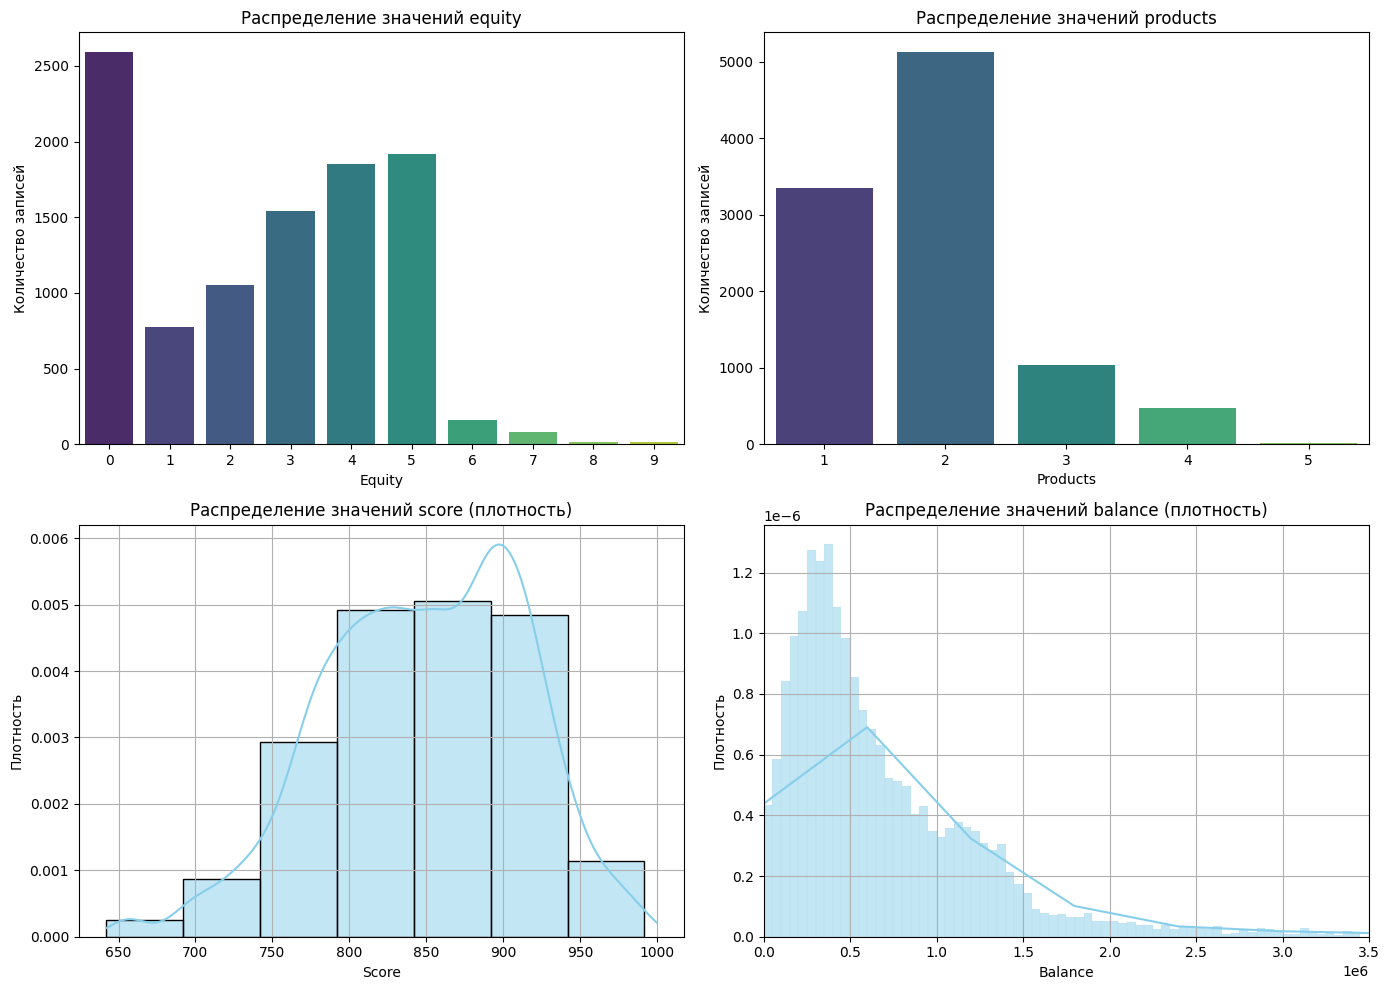

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

equity_counts = df['equity'].value_counts().reset_index()
equity_counts.columns = ['equity', 'count']
equity_counts = equity_counts.sort_values(by='equity')
sns.barplot(
    x='equity', y='count', 
    data=equity_counts, 
    palette='viridis', 
    ax=axs[0, 0])
axs[0, 0].set_title('Распределение значений equity')
axs[0, 0].set_xlabel('Equity')
axs[0, 0].set_ylabel('Количество записей')

products_counts = df['products'].value_counts().reset_index()
products_counts.columns = ['products', 'count']
products_counts = products_counts.sort_values(by='products')
sns.barplot(
    x='products', y='count', 
    data=products_counts, 
    palette='viridis', 
    ax=axs[0, 1])
axs[0, 1].set_title('Распределение значений products')
axs[0, 1].set_xlabel('Products')
axs[0, 1].set_ylabel('Количество записей')

sns.histplot(
    df['score'],
    bins=range(642, 1000, 50),
    kde=True,
    stat='density',
    color='skyblue',
    edgecolor='black',
    ax=axs[1, 0])
axs[1, 0].set_title('Распределение значений score (плотность)')
axs[1, 0].set_xlabel('Score')
axs[1, 0].set_ylabel('Плотность')
axs[1, 0].grid(True)

sns.histplot(
    df['balance'], 
    bins=range(0, 3500000, 50000), 
    kde=True, 
    stat='density', 
    color='skyblue', 
    edgecolor='black', 
    ax=axs[1, 1])
axs[1, 1].set_title('Распределение значений balance (плотность)')
axs[1, 1].set_xlabel('Balance')
axs[1, 1].set_ylabel('Плотность')
axs[1, 1].set_xlim(0, 3500000)
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

- Преобладают клиенты с 0 баллов активов, но клиентов с 3, 4 или 5 ощутимо больше, чем с 1 или 2.
- Чаще всего клиенты подписаны на 2 продукта или на 1. Количество клиентов, подписанных на 3 или 4 продукта относительно незначительно.
- Распределение скоринга клиентов близко к характерному куполу нормального, но наблюдается правостороннее смещение в зону верхних квантилей.
- Распределение баланса типчино для подобного рода признаков, характеризуется пиком в зоне низких и околосредних значений и длинным убывающим хвостом по мере роста показателя.

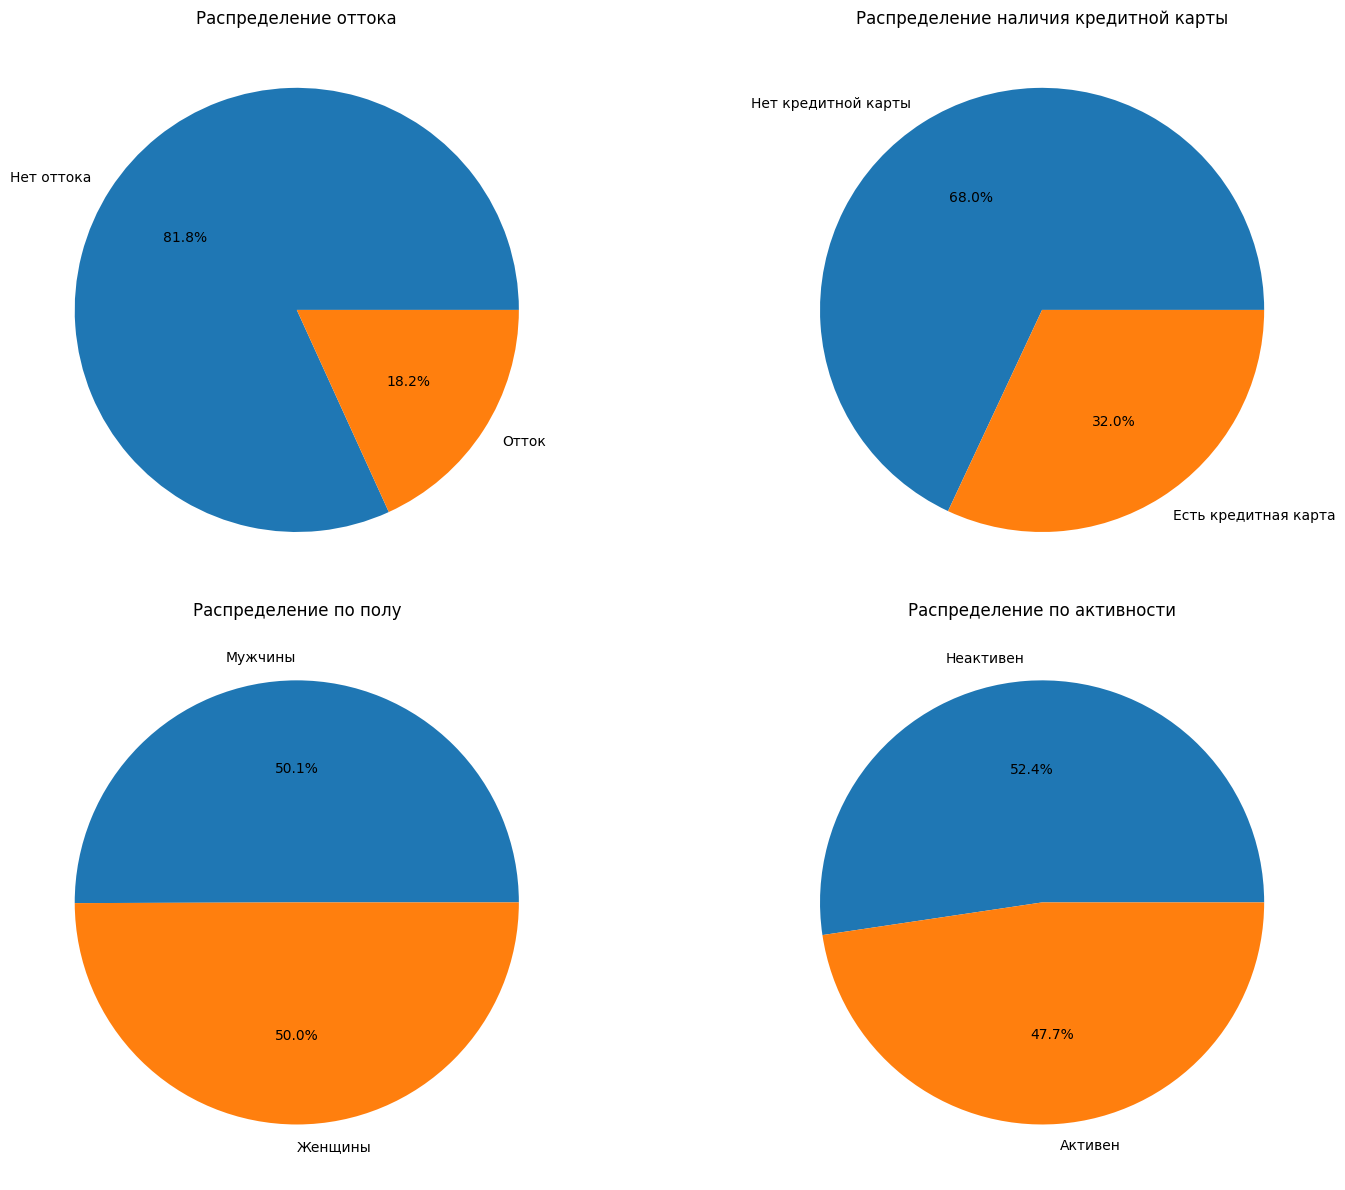

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

churn_counts = df['churn'].value_counts()
axs[0, 0].pie(
    churn_counts, 
    labels=['Нет оттока', 'Отток'], 
    autopct='%1.1f%%')
axs[0, 0].set_title('Распределение оттока')

credit_card_counts = df['credit_card'].value_counts()
axs[0, 1].pie(
    credit_card_counts, 
    labels=['Нет кредитной карты', 'Есть кредитная карта'], 
    autopct='%1.1f%%')
axs[0, 1].set_title('Распределение наличия кредитной карты')

gender_counts = df['gender'].value_counts()
axs[1, 0].pie(
    gender_counts, 
    labels=['Мужчины', 'Женщины'], 
    autopct='%1.1f%%')
axs[1, 0].set_title('Распределение по полу')

last_activity_counts = df['last_activity'].value_counts()
axs[1, 1].pie(
    last_activity_counts, 
    labels=['Неактивен', 'Активен'], 
    autopct='%1.1f%%')
axs[1, 1].set_title('Распределение по активности')

plt.tight_layout()
plt.show()

- Наблюдаю 18% оттока - ощутимо и больно.
- Лишь треть клиентов пользуются кредиткой - есть над чем поработать.
- Гендерное равноправие.
- 52.4% были определены как неактивные.

По вводным данным неактивными клиентами считаются те, кто 30 дней не запускал приложение. Исходя из такого показателя неактивности, требуется либо уточнение свойств данного признака у заказчика, либо более подробное его изучение. В данном случае мне остаётся только второй вариант. Я вернусь к этому в статистическом анализе.

#### Интервалы оттока

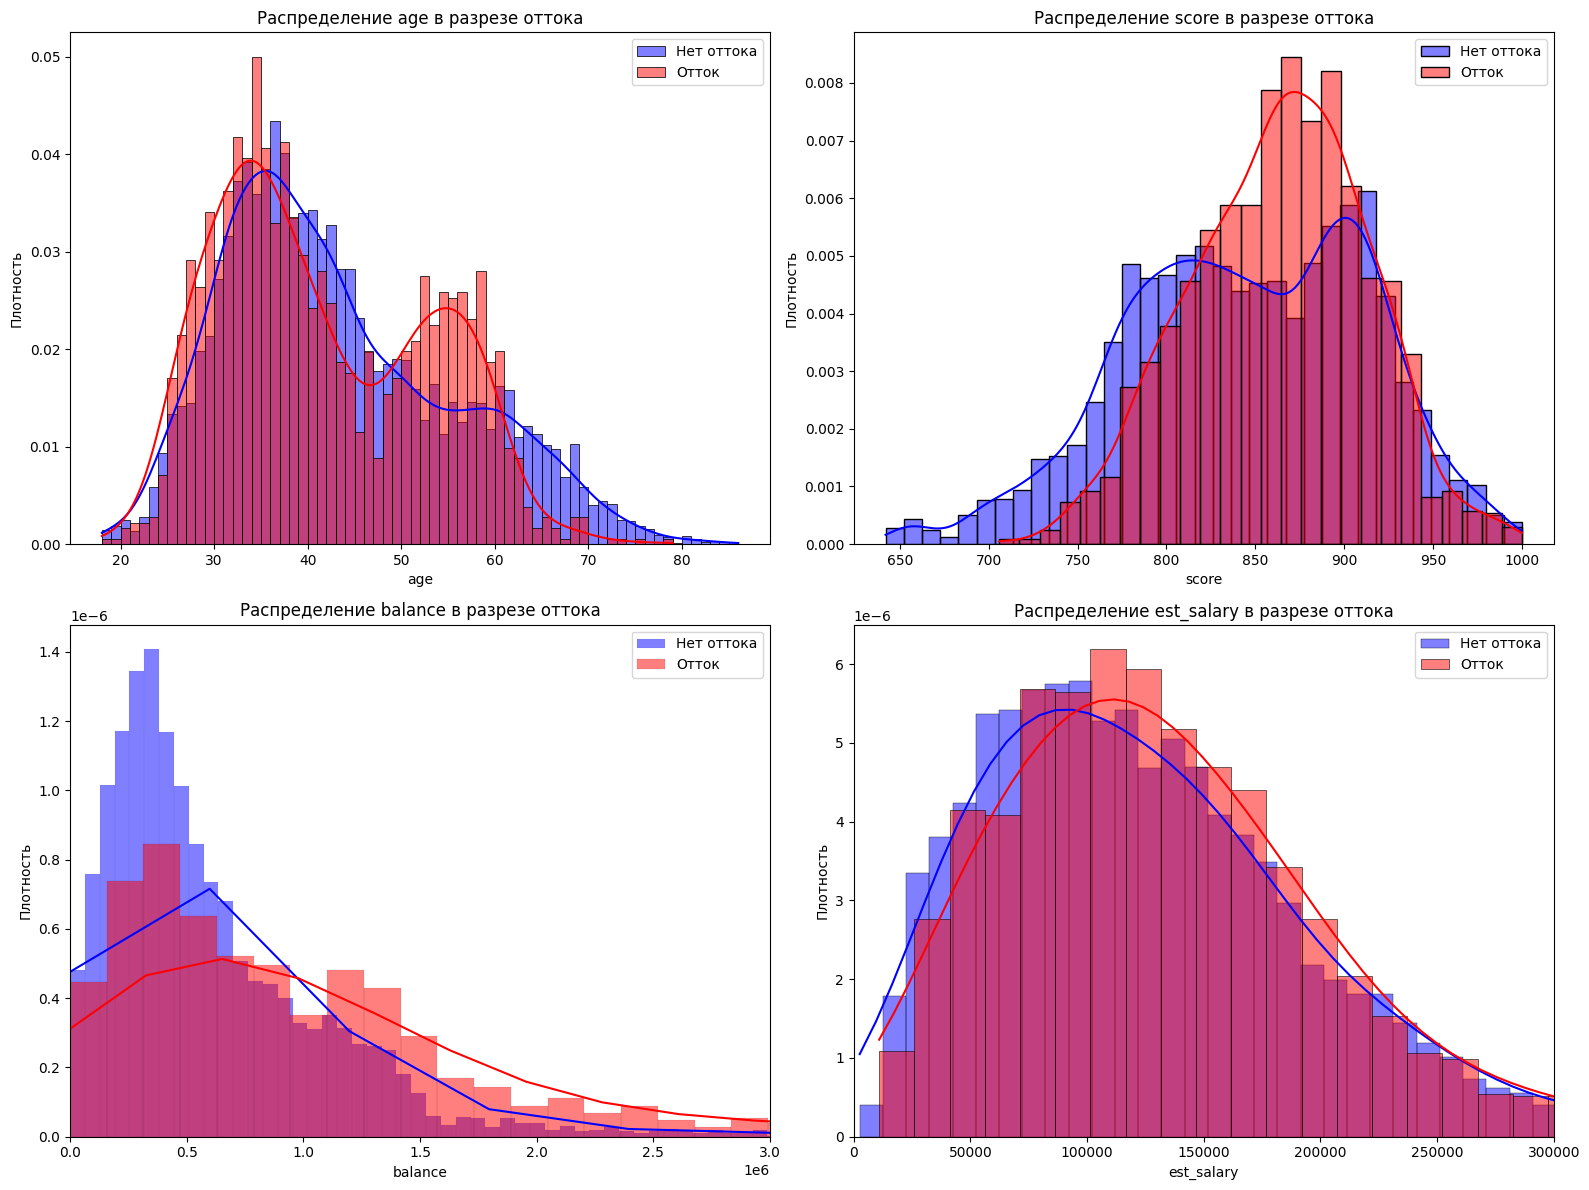

In [16]:
churn_1 = df[df['churn'] == 1]
churn_0 = df[df['churn'] == 0]
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
continuous_columns = ['age', 'score', 'balance', 'est_salary']

for i, column in enumerate(continuous_columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    if column == 'age':
        binwidth = 1 
    else:
        binwidth = None
    
    sns.histplot(
        churn_0[column], 
        kde=True, color='blue', 
        label='Нет оттока', 
        stat='density', ax=ax,
        binwidth=binwidth)  
    sns.histplot(
        churn_1[column], 
        kde=True, color='red', 
        label='Отток', 
        stat='density', ax=ax,
        binwidth=binwidth)
    ax.set_title(f'Распределение {column} в разрезе оттока')
    ax.set_xlabel(column)
    ax.set_ylabel('Плотность')
    ax.legend()

    if column == 'balance':
        ax.set_xlim(0, 3000000)
    elif column == 'est_salary':
        ax.set_xlim(0, 300000)

plt.tight_layout()
plt.show()

**Наблюдаются явные превышения оттока:**
  - **Возраст:** 25-34 и 50-60 лет
  - **Скоринг:** 820-920 баллов
  - **Баланс:** от 0.6 млн и до предельного правого значения 
  - **Доход:** от 100 до 220к 

Общий уровень оттока: 0.18


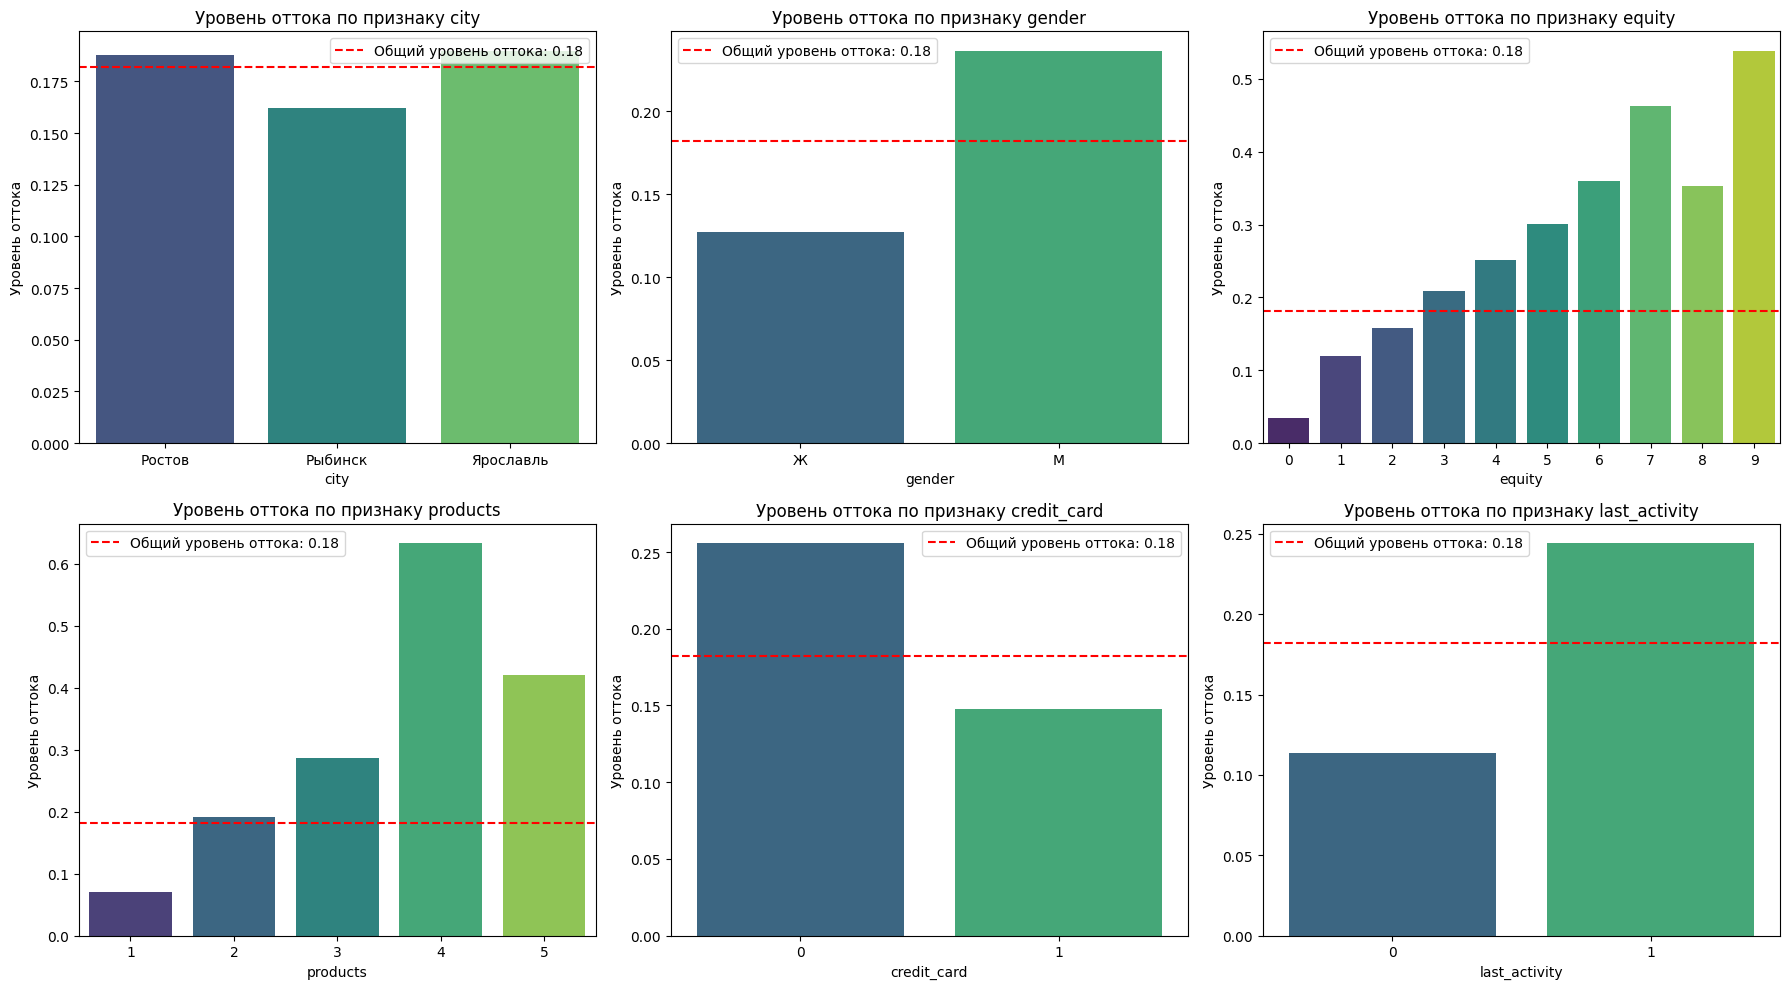

In [17]:
total_churn = df['churn'].mean()
print(f"Общий уровень оттока: {total_churn:.2f}")
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
discrete_columns = ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity']

for i, column in enumerate(discrete_columns):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    churn_rate = df.groupby(column)['churn'].mean()
    sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='viridis', ax=ax)
    ax.axhline(y=total_churn, color='red', linestyle='--', label=f'Общий уровень оттока: {total_churn:.2f}')
    ax.set_title(f'Уровень оттока по признаку {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Уровень оттока')
    ax.legend()

plt.tight_layout()
plt.show()

- Уровень оттока в Рыбинске ниже, чем в среднем по банку.
- Отточный клиент наверняка мужского пола.
- В целом чем больше у клиента активов, тем вероятнее его уход.
- Уходят клиенты, которые имеют 3 и более подписок.
- В то же время, уходит больше клиентов, не обладающих кредитной картой, чем тех, кто её имеет.
- Больше уходит клиентов, которые проявляли активность в последние 30 дней.

Клиенты, использующие несколько продуктов, могут иметь более высокие ожидания от банка. Если банк не оправдывает эти ожидания, это может привести к более высокому уровню оттока. Он менее лоялен и более подвержен переходу к конкурентам, особенно если чувствует, что может получить лучшие условия или обслуживание.<br><br>
Кредитные карты часто сопровождаются различными преимуществами и бонусами. Отсутствие кредитной карты может означать, что клиенты не пользуются дополнительными услугами и преимуществами, что может снизить их удовлетворенность и повысить вероятность оттока.

#### Портрет клиента в разрезе оттока

Посмотрю, нужно ли почистить данные по признакам с наибольшим разбросом.

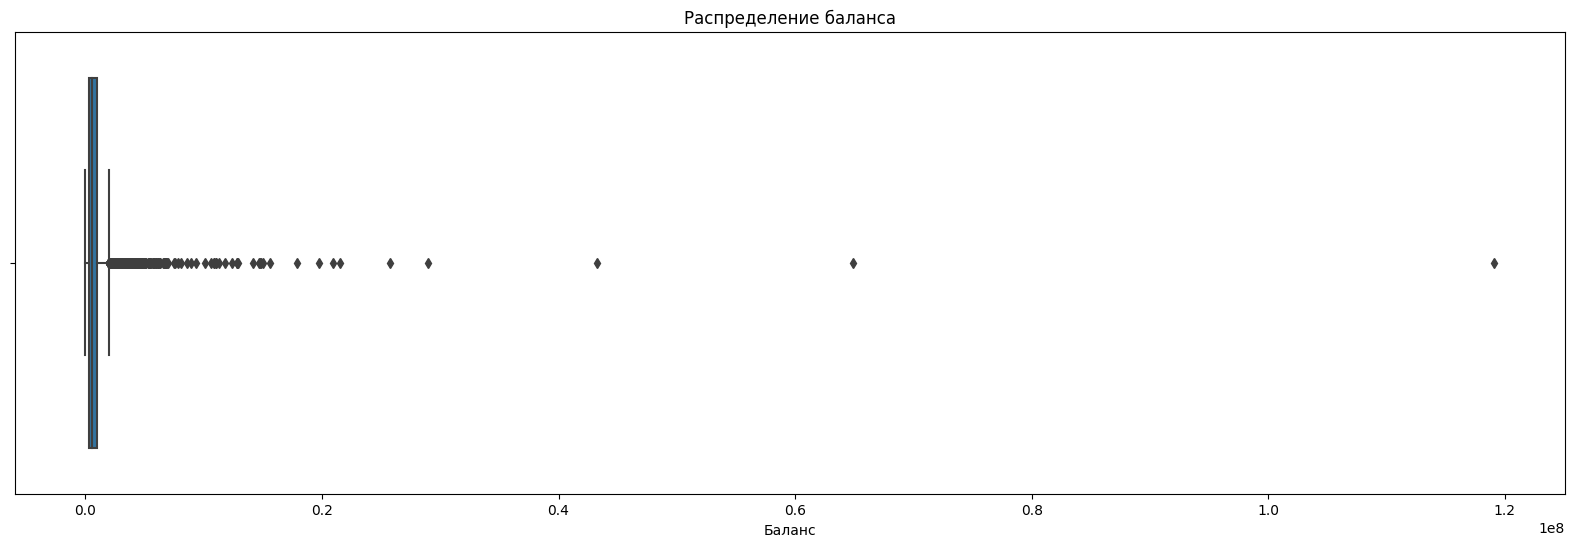

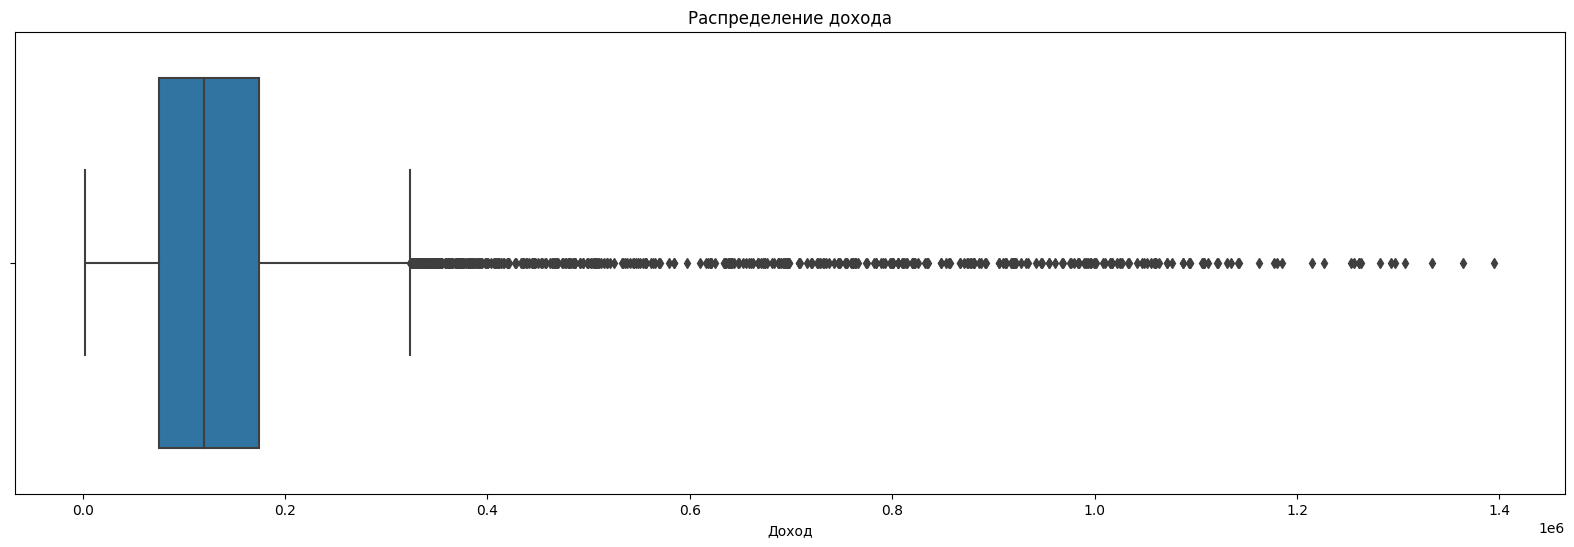

In [18]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='balance', data=df)
plt.title('Распределение баланса')
plt.xlabel('Баланс')
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(x='est_salary', data=df)
plt.title('Распределение дохода')
plt.xlabel('Доход')
plt.show()

В доходе выбросы идут довольно плотно, а баланс характеризуется большим разбросом, предельные значения которого будут искажать средние показатели. Почищу данные баланса и сформирую таблицу с усреднёнными характеристиками клиента в разрезе признака оттока.

In [19]:
df_cleared = df[df['balance'] < 20000000]

summary = df_cleared.groupby('churn').agg({
    'score': 'mean',
    'age': 'mean',  
    'equity': 'mean',  
    'products': 'mean',  
    'balance': 'median',  
    'est_salary': 'mean',  
    'city': lambda x: x.mode()[0],  
    'gender': lambda x: x.mode()[0],  
    'credit_card': 'mean',  
    'last_activity': 'mean'  
}).reset_index()

summary[['score', 'age', 'balance', 'est_salary']] = \
    summary[['score', 'age', 'balance', 'est_salary']].round().astype(int)
summary[['products', 'score', 'equity', 'credit_card', 'last_activity']] = \
    summary[['products','score', 'equity', 'credit_card', 'last_activity']].round(2)

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

summary = summary.T
summary.columns = ['Нет оттока', 'Отток']
summary['Разница'] = np.nan
numeric_columns = summary.index.difference(['city', 'gender'])

for col in numeric_columns:
    if summary.loc[col, 'Нет оттока'] != 0:
        difference = (
            (summary.loc[col, 'Отток'] - summary.loc[col, 'Нет оттока']) 
            / summary.loc[col, 'Нет оттока'] * 100)
        summary.loc[col, 'Разница'] = difference
    else:
        summary.loc[col, 'Разница'] = np.nan

summary['Разница'] = summary['Разница'].apply(
    lambda x: f"{x:.2f}%" if not np.isnan(x) else 'NA')
summary

,Нет оттока,Отток,Разница
churn,0,1,NA
score,838,863,2.98%
age,43,41,-4.65%
equity,3.27,3.79,15.90%
products,1.99,2.38,19.60%
balance,475293,780671,64.25%
est_salary,117314,146630,24.99%
city,Ярославль,Ярославль,NA
gender,Ж,М,NA
credit_card,0.67,0.55,-17.91%


У среднего отточного клиента больше собственности и существенно выше баланс, он скорее мужского пола.

### Корреляционный анализ

Буду использовать сравненение корреляций по Пирсону и по методу Phik для того, чтоб получить наиболее точное представление.
Чтобы построить матрицу по Пирсону воспользуюсь методом one-hot encoding, представив категориальные данные в числовом виде. Выведу две матрицы по методам и сводную таблицу с корреляциями по признаку оттока.

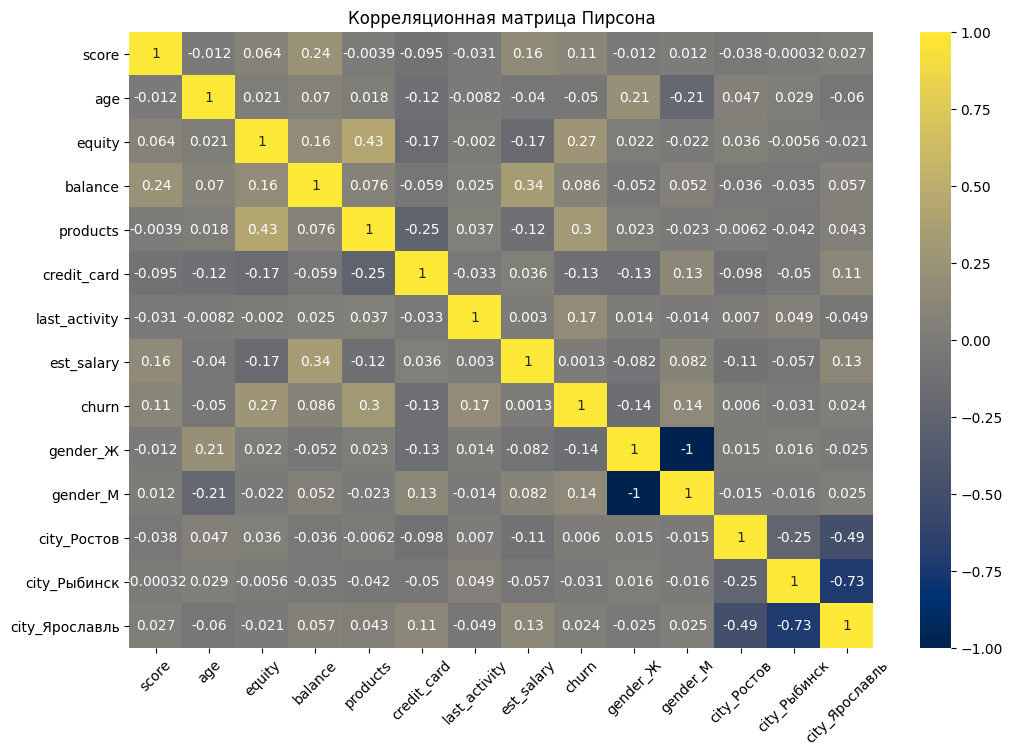

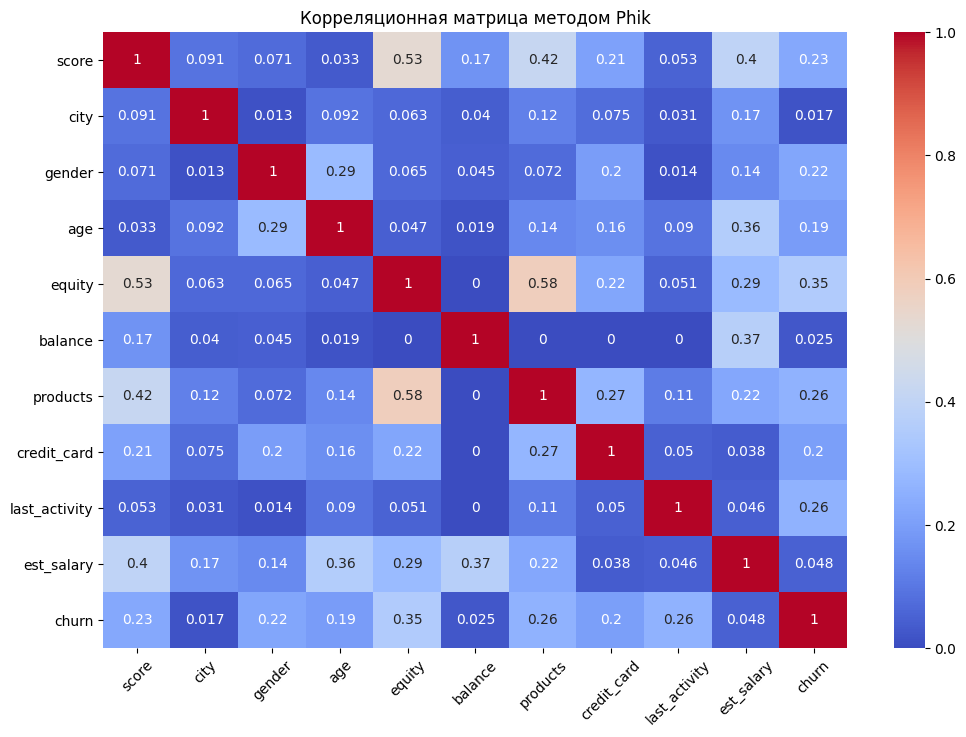

,Признак,Корреляция Пирсона,Корреляция Phik
0,age,-0.05,0.19
1,balance,0.09,0.02
2,churn,1.00,1.00
3,city,NaN,0.02
4,city_Ростов,0.01,NaN
5,city_Рыбинск,-0.03,NaN
6,city_Ярославль,0.02,NaN
7,credit_card,-0.13,0.20
8,equity,0.27,0.35
9,est_salary,0.00,0.05


In [20]:
df_encoded = pd.get_dummies(df, columns=['gender', 'city'])
df_encoded = df_encoded.drop(columns=['userid', 'age_na', 'balance_na'])
correlation_pearson = df_encoded.corr()
churn_pearson = correlation_pearson['churn'].sort_values(ascending=False)
df = df.drop(columns=['userid', 'age_na', 'balance_na'])
interval_cols = [
    'score', 'age', 'equity', 
    'balance', 'products', 
    'credit_card', 'last_activity', 
    'est_salary', 'churn']
correlation_phik = df.phik_matrix(interval_cols=interval_cols)
churn_phik = correlation_phik['churn'].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_pearson, annot=True, cmap='cividis')
plt.xticks(rotation=45)
plt.title('Корреляционная матрица Пирсона')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_phik, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.title('Корреляционная матрица методом Phik')
plt.show()

churn_correlation_df = churn_pearson.reset_index()
churn_phik_df = churn_phik.reset_index()
churn_correlation_df.columns = ['Признак', 'Корреляция Пирсона']
churn_phik_df.columns = ['Признак', 'Корреляция Phik']
combined_df = pd.merge(
    churn_correlation_df, churn_phik_df, on='Признак', how='outer')
combined_df = combined_df.sort_values(by='Признак').reset_index(drop=True)
combined_df

**Шкала Чеддока для интерпретации корреляций:**

| Корреляция (r)  | Интерпретация                        | Влияние на признаки                          |
|:---------------:|:------------------------------------:|:---------------------------------------------:|
| 0.0 - 0.1       | Очень слабая корреляция              | Практически отсутствует влияние              |
| 0.1 - 0.3       | Слабая корреляция                    | Влияние незначительное, практически неощутимое |
| 0.3 - 0.5       | Умеренная корреляция                 | Некоторое влияние, может быть заметно        |
| 0.5 - 0.7       | Заметная (средняя) корреляция        | Существенное влияние, явно выраженное        |
| 0.7 - 0.9       | Высокая корреляция                   | Сильное влияние, признаки тесно связаны      |
| 0.9 - 1.0       | Очень высокая корреляция             | Очень сильное влияние, практически линейная связь |





1. **Баланс**
    - Баланс имеет слабую позитивную корреляцию с целевым признаком по обоим метрикам, указывая на минимальное влияние на целевой признак.
2. **Кредитная карта**
     - Небольшая отрицательная корреляция по Пирсону указывает на слабое отрицательное влияние, тогда как позитивное влияние по Фику предполагает, что наличие кредитной карты может быть связано с определенным поведением или характеристикой.

3. **Собственность**
     - Позитивные корреляции по обоим метрикам показывают умеренное положительное влияние активов на целевой признак. Более высокие активы могут быть связаны с определенными характеристиками целевым признаком.

4. **Оценочная зарплата**
    - Очень слабое позитивное влияние как по Пирсону, так и по Фику указывает на то, что оценочная зарплата почти не влияет на целевую переменную.

5. **Продукты**
     - Высокие позитивные корреляции указывают на значительное влияние числа продуктов на целевую переменную.

6. **Скоринг**
     - Небольшое позитивное влияние по обоим метрикам указывает на то, что оценка имеет слабое, но положительное влияние на целевую переменную.

В общем, можно сказать, что products, equity и last_activity имеют наиболее заметное влияние на отток, в то время как остальные признаки показывают менее выраженное влияние.

### Статистический анализ

#### Гипотеза о разнице доходов

**H0:** средние доходы оставшихся и отточных клиентов равны.<br>
**H1:** средние доходы оставшихся и отточных клиентов различаются.

Для проверки гипотезы о равенстве доходов между двумя группами нужно сначала провести несколько предварительных тестов для проверки предположений, которые потребуются для выбора подходящего статистического критерия:
   - Определить, распределены ли данные нормально в каждой из групп. Для этого будет использоваться тест Шапиро-Уилка либо тест Колмогорова-Смирнова, в зависимости от размера выборки.
   - Проверить равенство дисперсий в двух группах. Для этого будет использоваться тест Левене.

Для проведения проверок и выбора критерия будет использоваться универсальный блок кода. Если данные распределены нормально, то будет использоваться критерий Стьюдента с соответствующим параметром в зависимости от равенства дисперсий. Если данные ненормальны, то будет применен критерий Манна-Уитни.

In [21]:
def stat_test(group1, group2, alpha=0.05):
    def normality_test(sample):
        if len(sample) > 5000:
            test_stat, p_value = st.kstest(
                sample, 'norm', args=(
                    sample.mean(), sample.std()))
            test_name = "Тест Колмогорова-Смирнова"
        else:
            test_stat, p_value = st.shapiro(sample)
            test_name = "Тест Шапиро-Уилка"
        return test_stat, p_value, test_name

    test_stat_1, p_value_norm_1, test_name_1 = normality_test(group1.dropna())
    test_stat_2, p_value_norm_2, test_name_2 = normality_test(group2.dropna())

    print(f"Для первой группы использован {test_name_1}: p-value = {p_value_norm_1:.4f}")
    print(
        "Данные нормально распределены." if p_value_norm_1 > alpha 
        else "Данные не распределены нормально.")
    print()

    print(f"Для второй группы использован {test_name_2}: p-value = {p_value_norm_2:.4f}")
    print(
        "Данные нормально распределены." if p_value_norm_2 > alpha 
        else "Данные не распределены нормально.")
    print()

    _, p_value_var = st.levene(group1.dropna(), group2.dropna())
    print(f"p-value для равенства дисперсий: {p_value_var:.4f}")

    if p_value_norm_1 > alpha and p_value_norm_2 > alpha:
        if p_value_var > alpha:
            t_stat, p_value = st.ttest_ind(
                group1.dropna(), 
                group2.dropna(), 
                equal_var=True)
            test_type = "t-test для независимых выборок (равные дисперсии)"
        else:
            t_stat, p_value = st.ttest_ind(
                group1.dropna(), 
                group2.dropna(), 
                equal_var=False)
            test_type = "t-test для независимых выборок (неравные дисперсии)"
    else:
        u_stat, p_value = st.mannwhitneyu(group1.dropna(), group2.dropna())
        test_type = "тест Манна-Уитни"

    print(f"Используем {test_type}")
    print(f"p-value теста: {p_value:.4f}")
    if p_value < alpha:
        print("Отклоняем нулевую гипотезу: средние значения различаются.")
        print()
    else:
        print("Не отклоняем нулевую гипотезу: средние значения не различаются.")
        print()

    mean_group1 = group1.mean()
    mean_group2 = group2.mean()
    print(f"Среднее значение первой группы: {mean_group1:.2f}")
    print(f"Среднее значение второй группы: {mean_group2:.2f}")

    if mean_group1 > mean_group2:
        print("Среднее значение первой группы больше.")
    elif mean_group2 > mean_group1:
        print("Среднее значение второй группы больше.")
    else:
        print("Средние значения равны.")
    
    return p_value

In [22]:
p_value = stat_test(churn_1['est_salary'], churn_0['est_salary'])

Для первой группы использован Тест Шапиро-Уилка: p-value = 0.0000
Данные не распределены нормально.

Для второй группы использован Тест Колмогорова-Смирнова: p-value = 0.0000
Данные не распределены нормально.

p-value для равенства дисперсий: 0.0095
Используем тест Манна-Уитни
p-value теста: 0.0002
Отклоняем нулевую гипотезу: средние значения различаются.

Среднее значение первой группы: 148243.01
Среднее значение второй группы: 147783.20
Среднее значение первой группы больше.


Проведенный тест указывает на то, что доходы отточных и оставшихся клиентов различаются. Проверю, корректно ли были определены параметры выборок и выбран критерий. Кажется, что разница между средними несущественна. Оценю визуально распределение данных в группах при помощи Q-Q графика.

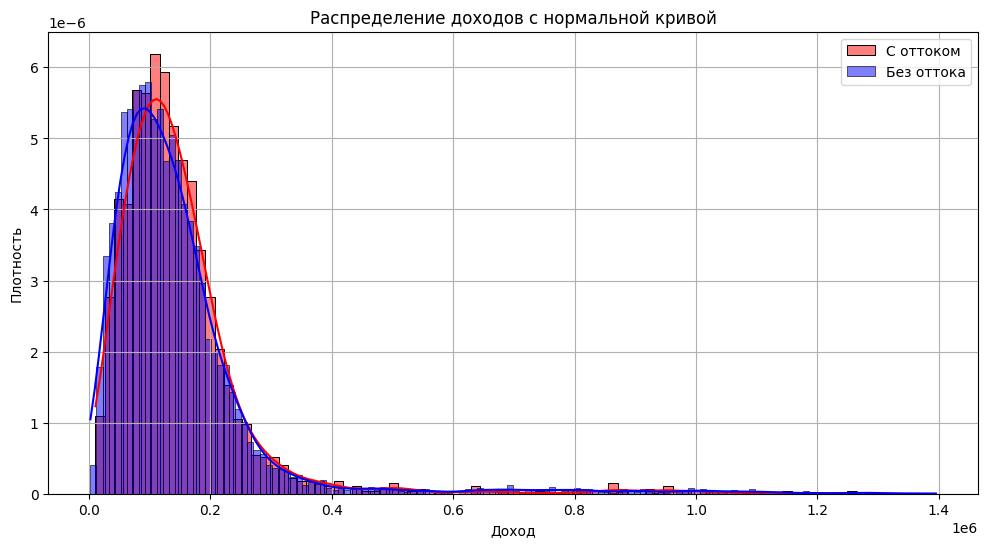

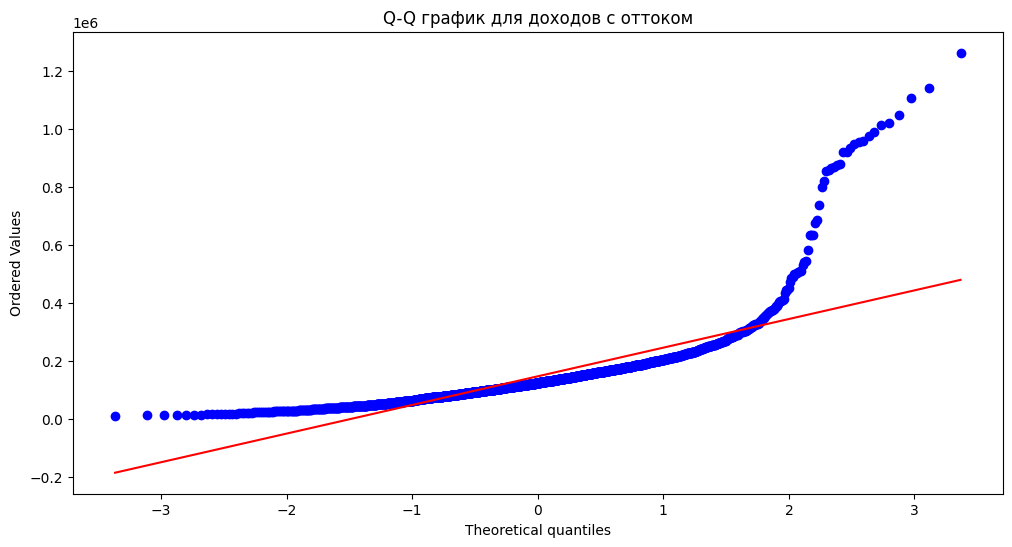

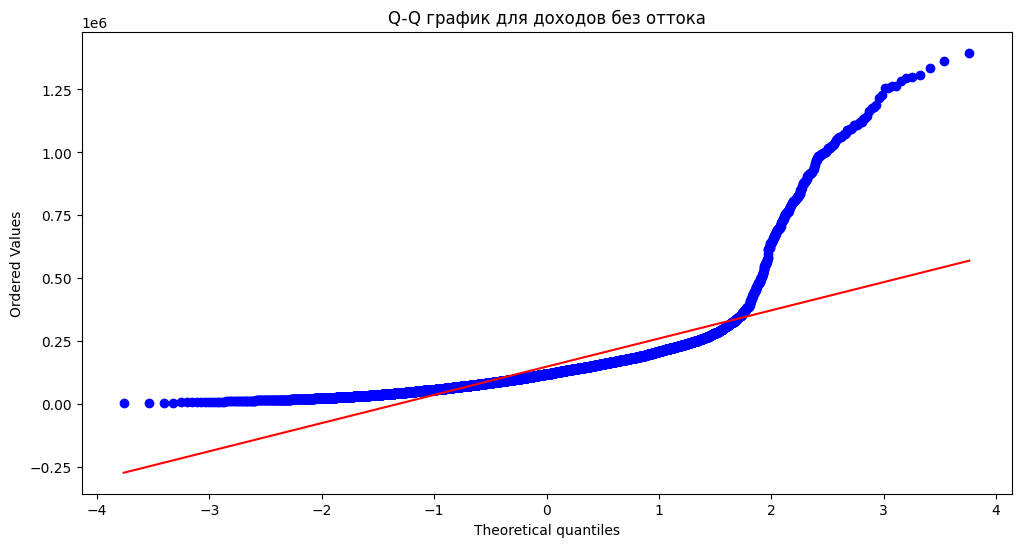

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(
    churn_1['est_salary'].dropna(), 
    kde=True, stat='density', 
    color='red', label='С оттоком')

sns.histplot(
    churn_0['est_salary'].dropna(), 
    kde=True, stat='density', 
    color='blue', label='Без оттока')
plt.title('Распределение доходов с нормальной кривой')
plt.xlabel('Доход')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
st.probplot(
    churn_1['est_salary'].dropna(), 
    dist="norm", 
    plot=plt)
plt.title('Q-Q график для доходов с оттоком')
plt.show()

plt.figure(figsize=(12, 6))
st.probplot(
    churn_0['est_salary'].dropna(), 
    dist="norm", plot=plt)
plt.title('Q-Q график для доходов без оттока')
plt.show()

Действительно, распределение ближе к экспоненциальному. Значит тест Манна-Уитни выбран корректно. Разница между средними значениями составляет примерно 460 рублей. На первый взгляд, эта разница кажется небольшой. Однако, статистическая значимость не определяется только разницей в средних значениях, но также учитывает вариабельность данных и размер выборки. Таким образом считаем, что средний доход отточных клиентов несколько выше.

#### Гипотеза об активности

**H0:** Активность клиента не влияет на вероятность оттока.<br>
**H1:** Активность клиента влияет на вероятность оттока.<br><br>
Так как эти признаки бинарны, подходящим тестом для проверки этой гипотезы является тест хи-квадрат для независимости. Этот тест проверяет, есть ли статистически значимая связь между двумя категориальными переменными. Он создаст таблицу сопряженности — матрицу, показывающую частоты или количество наблюдений для комбинаций значений категориальных переменных.

In [24]:
def binar_test(df, col1, col2, alpha=0.05):
    contingency_table = pd.crosstab(df[col1], df[col2])
    print("Таблица сопряженности:\n", contingency_table)
    print()
    
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi2-statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print()

    if (contingency_table.values < 5).any():
        if contingency_table.shape == (2, 2):
            odds_ratio, p_value_fisher = fisher_exact(contingency_table)
            print(f"p-value для теста Фишера: {p_value_fisher:.4f}")
            p_value = p_value_fisher
        else:
            print("Тест Фишера применим только для таблиц 2x2.")
    
    if p_value < alpha:
        print("Отклоняем нулевую гипотезу: существует статистически значимая зависимость.")
    else:
        print("Не отклоняем нулевую гипотезу: статистически значимой зависимости не обнаружено.")

In [25]:
binar_test(df, 'last_activity', 'churn')

Таблица сопряженности:
 churn             0     1
last_activity            
0              4223   542
1              3957  1278

Chi2-statistic: 283.9491
p-value: 0.0000

Отклоняем нулевую гипотезу: существует статистически значимая зависимость.


Тест показывает, что активность клиента влияет на вероятность оттока. Однако, как видно из таблицы сопряженности, зависимость эта обратная.
- Неактивные клиенты (last_activity = 0): из 4765 таких клиентов, 542 (или 11.4%) имеют отток, а 4223 (или 88.6%) — нет.
- Активные клиенты (last_activity = 1): из 5235 таких клиентов, 1278 (или 24.4%) имеют отток, а 3957 (или 75.6%) — нет.<br><br>

Таким образом, активные пользователи более подвержены оттоку. Это может подразумевать, что активные пользователи, возможно, сталкиваются с какими-то проблемами или недостатками, которые приводят к оттоку, или что активность сама по себе может быть связана с негативными факторами, способствующими оттоку.

### Сегментация клиентов

Опираясь на определённые выше отточные интервалы и признаки, сформирую три сегмента клиентов, процент оттока среди которых будет наиболее высоким. 

#### Сегмент 1

**Молодой клиент с высоким баллом и высоким балансом.**<br>
Возраст 25-34 года.<br>
Баланс более 600к.<br>
Рейтинг более 820 баллов.<br>

In [26]:
segment_1 = df.query("age >= 25 and age <= 34 and balance > 600000 and score >= 820")
print(f"Размер сегмента: {segment_1['churn'].count()} человек")
print(f"Средний уровень оттока: {segment_1['churn'].mean() * 100:.2f}%")
print(f"Рейтинг отточности: {(segment_1['churn'].mean() * segment_1['churn'].count() / 100):.2f}")

Размер сегмента: 545 человек
Средний уровень оттока: 52.84%
Рейтинг отточности: 2.88


Этот клиент, вероятно, активен, имеет значительный баланс на счету и высокий скоринг. Он может быть менее склонен к оттоку, если у него не очень высокие активы или он менее активен. Однако, учитывая высокие показатели, его поведение в этих интервалах также может указывать на высокий риск оттока.

#### Сегмент 2

**Клиент в возрасте с высокими активами и отсутствием кредитной карты.**<br>
Возраст 50-61 лет.<br>
Баллы активов от 3.<br>
Нет кредитной карты.<br>

In [27]:
segment_2 = df.query("age >= 50 and age <= 61 and credit_card == 0 and equity >= 3")
print(f"Размер сегмента: {segment_2['churn'].count()} человек")
print(f"Средний уровень оттока: {segment_2['churn'].mean() * 100:.2f}%")
print(f"Рейтинг отточности: {(segment_2['churn'].mean() * segment_2['churn'].count() / 100):.2f}")

Размер сегмента: 509 человек
Средний уровень оттока: 42.04%
Рейтинг отточности: 2.14


Этот клиент более зрелый. Вероятно, с высоким балансом и доходом. Отсутствие кредитной карты может быть дополнительным фактором риска.

#### Сегмент 3

**Клиент с высокой активностью и множеством продуктов.**<br>
Заходил в приложение в последние 30 дней.<br>
Подписан на 3 и более продуктов.

In [28]:
segment_3 = df.query("products >= 3 and last_activity == 1")
print(f"Размер сегмента: {segment_3['churn'].count()} человек")
print(f"Средний уровень оттока: {segment_3['churn'].mean() * 100:.2f}%")
print(f"Рейтинг отточности: {(segment_3['churn'].mean() * segment_3['churn'].count() / 100):.2f}")

Размер сегмента: 824 человек
Средний уровень оттока: 47.45%
Рейтинг отточности: 3.91


Клиенты, которые используют много разных продуктов банка, могут сталкиваться с проблемами, если эти продукты не работают хорошо вместе или обслуживание не на высоте. Это может вызвать у них недовольство и желание уйти из банка.

#### Приоритизация сегментов

Исходя из относительного коэффициента рейтинга отточности, сегменты следует расположить следующим образом в порядке убывания значимости:
1. Сегмент 3
2. Сегмент 1
3. Сегмент 2

### Анализ отточных сегментов

In [29]:
def get_segment_stats(segment):
    return {
        'score': round(segment['score'].mean()),
        'age': round(segment['age'].mean()),
        'equity': segment['equity'].mean(),
        'products': segment['products'].mean(),
        'balance': round(segment['balance'].median()),
        'est_salary': round(segment['est_salary'].mean()),
        'city': segment['city'].mode()[0],
        'gender': segment['gender'].mode()[0],
        'credit_card': round(segment['credit_card'].mean(), 2),
        'last_activity': round(segment['last_activity'].mean(), 2)}
    
segment_1_stats = get_segment_stats(segment_1)
segment_2_stats = get_segment_stats(segment_2)
segment_3_stats = get_segment_stats(segment_3)
segment_stats_df = pd.DataFrame({
    'Segment 1': segment_1_stats,
    'Segment 2': segment_2_stats,
    'Segment 3': segment_3_stats})
segment_stats_df

,Segment 1,Segment 2,Segment 3
score,893,861,854
age,31,56,43
equity,4.25,4.24,3.83
products,2.22,2.36,3.50
balance,967336,990378,707120
est_salary,167293,126803,135008
city,Ярославль,Ярославль,Ярославль
gender,М,Ж,М
credit_card,0.57,0.00,0.47
last_activity,0.60,0.58,1.00


Как видно из сводной таблицы, за исключением тех параметров, определяющих сегмент и которые задавались вручную, по всем остальным признакам портреты среднего клиента внутри сегмента достаточно близки друг к другу. Это человек с высоким доходом, высоким балансом, высоким рейтингом и пользующийся продуктами банка.

## Разработка рекомендаций

<div style="border: 2px solid #000; padding: 10px; border-radius: 5px;">
    
**Segment 3 (Активные клиенты с большим количеством продуктов)**
- Средний возраст: 43
- Средний скоринг: 854
- Средний баланс: 707120
- Средний доход: 135008
- Среднее количество продуктов: 3.50
- Наличие кредитной карты: 0.47
- Средний уровень активности: 1.00
- Пол: мужской

Сегмент, которому следует уделить наибольшее внимание, т.к. в нём наибольшая доля оттока.<br><br>
**Рекомендации:**<br>
Возможно, клиенты не удовлетворены качеством продуктов банка или испытывают сложности при взаимодействии. Следует провести анализ и оптимизацию продуктов, чтоб улучшить их эффективность и интеграцию. Рекомендуется внедрение программы обратной связи, регулярное проведение проверок удовлетворенности клиентов и выяснение их потребностей.
</div>

<div style="border: 2px solid #000; padding: 10px; border-radius: 5px;">
    
**Segment 1 (Молодые клиенты с высоким скорингом и балансом)**
- Средний возраст: 31
- Средний скоринг: 893
- Средний баланс: 967336
- Средний доход: 167293
- Среднее количество продуктов: 2.22
- Наличие кредитной карты: 0.57
- Средний уровень активности: 0.60
- Пол: мужской
    
**Рекомендации:**<br>
Клиентов в этом сегменте могут заинтересовать эксклюзивные предложения по инвестициям, премиум-продукты и индивидуальные консультации. Учитывая их высокую активность и достаточные ресурсы, следует инвестировать в улучшение качества обслуживания и дополнительных услуг. Рекомендуется создание программ лояльности и премирование бонусами за активное использование продуктов банка.
    
</div>    

<div style="border: 2px solid #000; padding: 10px; border-radius: 5px;">

**Segment 2 (Пожилые клиенты с высоким балансом, но без кредитной карты)**

- Средний возраст: 56
- Средний скоринг: 861
- Средний баланс: 990378
- Средний доход: 126803
- Среднее количество продуктов: 2.36
- Наличие кредитной карты: 0.00
- Средний уровень активности: 0.58
- Пол: женский

**Рекомендации:**
Эти клиенты не используют кредитные карты, что может быть связано с опасениями или предпочтениями. Для пенсионеров или клиентов, приближающихся к пенсионному возрасту, следует предложить финансовые консультации и планирование. Это может помочь им более эффективно управлять своими активами. Рекомендуется обдумать возможность создания продуктов, соответствующих их финансовым потребностям и интересам, например, инвестиционные продукты или пенсионные планы.

</div> 

**Общие рекомендации:**<br>
Банк теряет клиентов, обладающих значительными ресурсами и, вероятно, инетересующихся и разбирающихся в банковских продуктах.
Возможно, они находят более привлекательное предложение у конкурентов. Рекомендуется сосредоточиться на создании программ лояльности и привелегий, снижать комиссии на транзакции с большими суммами, повышать начисления процентов на остаток по счёту,  предоставлять эксклюзивные пакетные услуги, основанные на потребностях таких клиентов.

# Часть 2: SQL базы данных

## Задача

Проанализировать базу данных онлайн-библиотеки:
- Посчитать, сколько книг вышло после 1 января 2000 года;
- Для каждой книги посчитать количество обзоров и среднюю оценку;
- Определить издательство, которое выпустило наибольшее число книг толще 50 страниц;
- Определить автора с самой высокой средней оценкой книг;
- Посчитать среднее количество обзоров от пользователей, которые поставили больше 48 оценок.

## Описание данных

| **Таблица**     | **Поле**          | **Описание**                         |
|-----------------|-------------------|--------------------------------------|
| **books**       | book_id           | Идентификатор книги                  |
|                 | author_id         | Идентификатор автора                 |
|                 | title             | Название книги                       |
|                 | num_pages         | Количество страниц                   |
|                 | publication_date  | Дата публикации книги                |
|                 | publisher_id      | Идентификатор издателя               |
| **authors**     | author_id         | Идентификатор автора                 |
|                 | author            | Имя автора                           |
| **publishers**  | publisher_id      | Идентификатор издательства           |
|                 | publisher         | Название издательства                |
| **ratings**     | rating_id         | Идентификатор оценки                 |
|                 | book_id           | Идентификатор книги                  |
|                 | username          | Имя пользователя, оставившего оценку |
|                 | rating            | Оценка книги                         |
| **reviews**     | review_id         | Идентификатор обзора                 |
|                 | book_id           | Идентификатор книги                  |
|                 | username          | Имя автора обзора                    |
|                 | text              | Текст обзора                         |


## Схема базы данных

![scheme_1589269096.png](https://raw.githubusercontent.com/Vendor62/Training-projects-DA/main/catering_maps/scheme_1589269096.png)

## Подключение к базе

In [30]:
db_config = {'user': 'praktikum_student', 
             'pwd': 'Sdf4$2;d-d30pp', 
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432,
             'db': 'data-analyst-final-project-db'} 
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
engine = create_engine(connection_string, connect_args={'sslmode':'require'})
query = '''SELECT * FROM books LIMIT 5'''
con=engine.connect()
pd.io.sql.read_sql(sql=text(query), con = con)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope #1),322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before Columbus,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


## Осмотр таблиц

In [31]:
def get_5_rows(table, db_config):
    connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
    engine = create_engine(connection_string, connect_args={'sslmode': 'require'})
    query_first_5_rows = f'SELECT * FROM {table} LIMIT 5'
    query_table_info = f'''
    SELECT 
        column_name, 
        data_type 
    FROM 
        information_schema.columns 
    WHERE 
        table_name = '{table}';
    '''
    
    with engine.connect() as connection:
        df_first_5_rows = pd.read_sql(sql=text(query_first_5_rows), con=connection)
        df_table_info = pd.read_sql(sql=text(query_table_info), con=connection)
        df_full = pd.read_sql(sql=text(f'SELECT * FROM {table}'), con=connection)

    print(f"Общая информация по таблице '{table}'")
    print()
    print(f"Количество строк: {len(df_full)}")
    print(f"Количество столбцов: {len(df_full.columns)}")
    print()
    print("Имя столбцов и их типы:")
    print(df_table_info.to_string(index=False))
    print("\nПроверка на пропущенные значения:")
    print(df_full.isnull().sum())
    print()
    print(f"Количество дублирующихся строк: {df_full.duplicated().sum()}")
    print()
    return df_first_5_rows

In [32]:
display(get_5_rows('books', db_config))

Общая информация по таблице 'books'

Количество строк: 1000
Количество столбцов: 6

Имя столбцов и их типы:
     column_name data_type
         book_id   integer
       author_id   integer
       num_pages   integer
publication_date      date
    publisher_id   integer
           title      text

Проверка на пропущенные значения:
book_id             0
author_id           0
title               0
num_pages           0
publication_date    0
publisher_id        0
dtype: int64

Количество дублирующихся строк: 0



,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope #1),322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before Columbus,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


In [33]:
display(get_5_rows('authors', db_config))

Общая информация по таблице 'authors'

Количество строк: 636
Количество столбцов: 2

Имя столбцов и их типы:
column_name data_type
  author_id   integer
     author      text

Проверка на пропущенные значения:
author_id    0
author       0
dtype: int64

Количество дублирующихся строк: 0



,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd


**При первичном осмотре не было обнаружено повреждений, дубликатов либо пропущенных значений. Типы данных установлены корректно. Данные готовы к дальнейше обработке.**

## Подсчет количества книг

Посчитать, сколько книг вышло после 1 января 2000 года.

In [34]:
query = '''
    SELECT COUNT(*) 
    FROM books
    WHERE publication_date > '2000-01-01';
'''
result = pd.io.sql.read_sql(sql=text(query), con=con)
result

,count
0,819


В базе содержится 819 книг с датой выхода после 1 января 2000 года.

## Подсчет оценок и обзоров

Для каждой книги посчитать количество обзоров и среднюю оценку.

In [40]:
query = '''
    SELECT b.title,
           COUNT(DISTINCT rv.review_id) AS reviews_count, 
           AVG(rt.rating) AS avg_rating
    FROM books AS b 
    LEFT JOIN reviews AS rv ON b.book_id = rv.book_id
    LEFT JOIN ratings AS rt ON b.book_id = rt.book_id
    GROUP BY b.book_id
    ORDER BY avg_rating DESC, reviews_count DESC
'''
result = pd.io.sql.read_sql(sql=text(query), con=con)
result

,title,reviews_count,avg_rating
0,A Dirty Job (Grim Reaper #1),4,5.00
1,School's Out—Forever (Maximum Ride #2),3,5.00
2,Moneyball: The Art of Winning an Unfair Game,3,5.00
3,Arrows of the Queen (Heralds of Valdemar #1),2,5.00
4,Wherever You Go There You Are: Mindfulness Meditation in Everyday Life,2,5.00
...,...,...,...
995,The World Is Flat: A Brief History of the Twenty-first Century,3,2.25
996,Drowning Ruth,3,2.00
997,His Excellency: George Washington,2,2.00
998,Junky,2,2.00


## Поиск издательств

Определить издательство, которое выпустило наибольшее число книг толще 50 страниц.

In [36]:
query = '''
    SELECT p.publisher,
           COUNT(b.book_id) as cnt   
    FROM publishers AS p 
    JOIN books AS b ON p.publisher_id=b.publisher_id
    WHERE b.num_pages > 50
    GROUP BY p.publisher
    ORDER BY cnt DESC
    LIMIT 5;
'''
result = pd.io.sql.read_sql(sql=text(query), con=con)
result

,publisher,cnt
0,Penguin Books,42
1,Vintage,31
2,Grand Central Publishing,25
3,Penguin Classics,24
4,Bantam,19


Наибольшее число книг толще 50 страниц - 42, выпущено издательством Penguin Books.

## Определение автора

Определить автора с самой высокой средней оценкой книг. Учитывать только книги с 50 и более оценками.

In [37]:
query = '''
    WITH 
    filter AS (
            SELECT b.book_id,
                   b.author_id,
                   COUNT(rt.rating) 
            FROM books AS b
            JOIN ratings AS rt ON b.book_id = rt.book_id
            GROUP BY b.book_id, b.author_id
            HAVING COUNT(rt.rating) >= 50
    ),
    rates AS (
            SELECT b.author_id,
                   a.author,
            AVG(rt.rating) AS avg_rating
            FROM filter AS f
            JOIN books AS b ON f.book_id = b.book_id
            JOIN ratings AS rt ON b.book_id = rt.book_id
            JOIN authors AS a ON b.author_id = a.author_id
            GROUP BY b.author_id, a.author
    )
    SELECT author,
           avg_rating
    FROM rates
    ORDER BY avg_rating DESC
    LIMIT 5;

'''
result = pd.io.sql.read_sql(sql=text(query), con=con)
result

,author,avg_rating
0,J.K. Rowling/Mary GrandPré,4.29
1,Markus Zusak/Cao Xuân Việt Khương,4.26
2,J.R.R. Tolkien,4.25
3,Louisa May Alcott,4.19
4,Rick Riordan,4.08


Самая высокая средняя оценка книг у J.K.Rowling - 4.29.

## Подсчет количества обзоров

Посчитать среднее количество обзоров от пользователей, которые поставили больше 48 оценок.

In [38]:
query = '''
    WITH 
    users AS (
            SELECT rt.username,
                   COUNT(rt.rating_id) AS rating_cnt
            FROM ratings AS rt
            GROUP BY rt.username
            HAVING COUNT(rt.rating_id) > 48
    ),
    counts AS (
            SELECT rv.username,
                   COUNT(rv.review_id)
            FROM reviews AS rv
            WHERE rv.username IN (SELECT username FROM users)
            GROUP BY rv.username
    )
    SELECT AVG(count)
    FROM counts;
'''
result = pd.io.sql.read_sql(sql=text(query), con=con)
result

,avg
0,24.00


Cреднее количество обзоров от пользователей, которые поставили больше 48 оценок - 24.

## Финальный вывод

В ходе данного исследования была изучена структура базы даннных онлайн-библиотеки. Данные проверены на пропуски, дубликаты и соответствие типов. Проблем не выявлено.<br><br>
Также были даны ответы на поставленные задачи:<br>
- В базе содержится 819 книг с датой выхода после 1 января 2000 года. Общее количество книг - 1000.
- Сформирована таблица, содержащая наименование книги, количество обзоров, среднюю пользовательскую оценку. Всего 1000 строк. 
- Определены первые 5 издателей, выпустивших наибольшее количество книг толщиной более 50 листов.
- Определены первые 5 авторов, чьи книги получили наибольшую среднюю пользовательскую оценку.
- Cреднее количество обзоров от пользователей, которые поставили больше 48 оценок - 24.

# Часть 3: построение дополнительных графиков

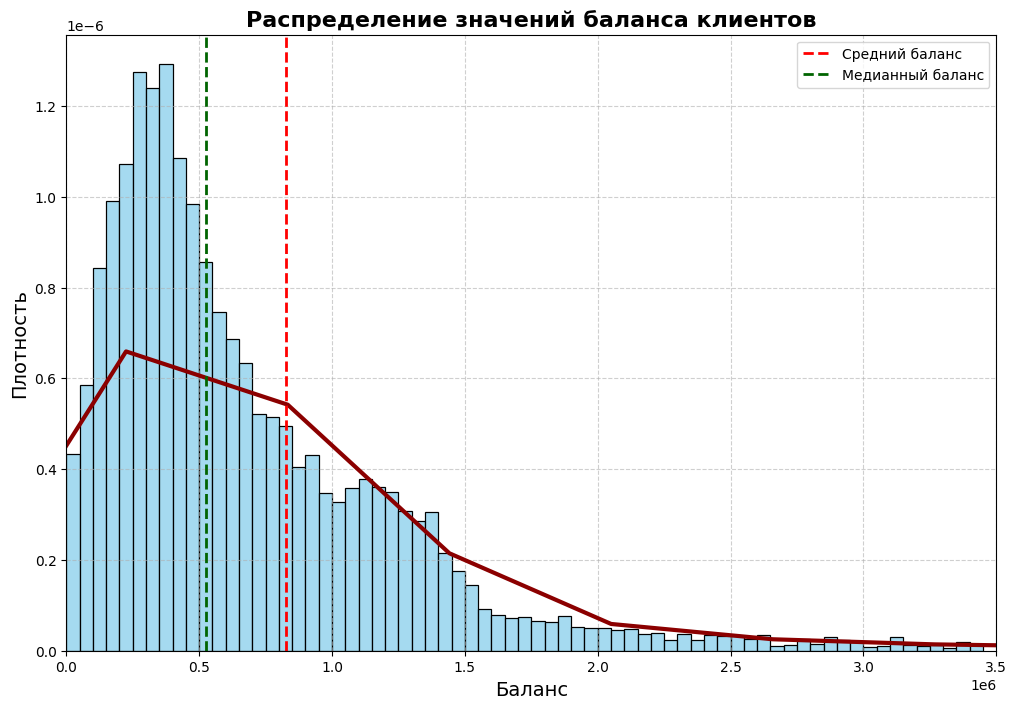

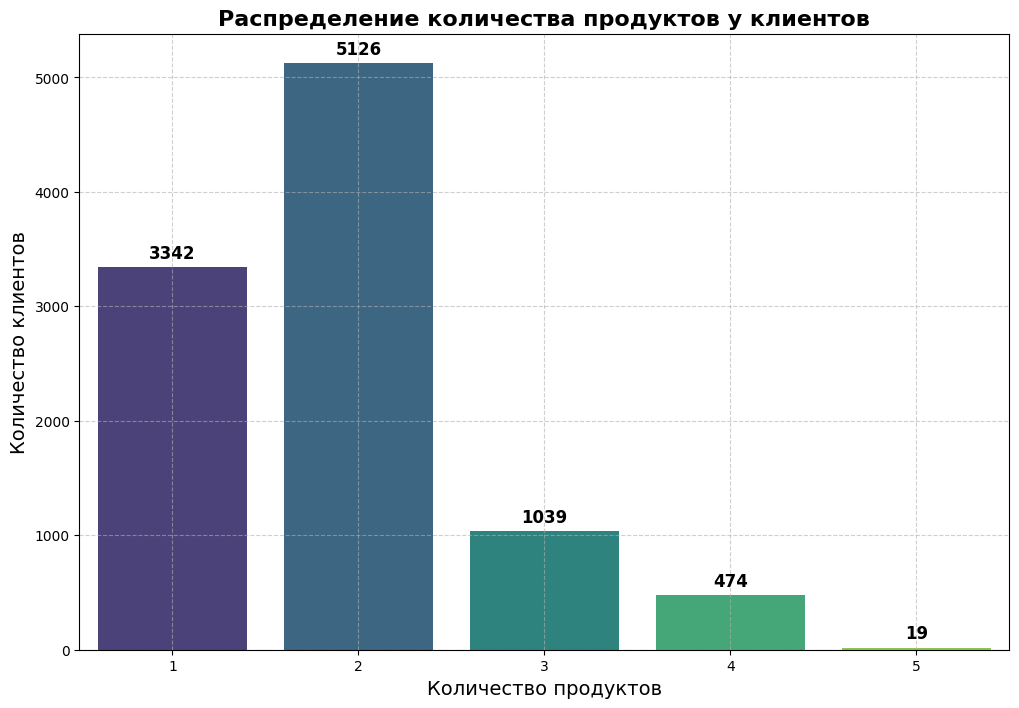

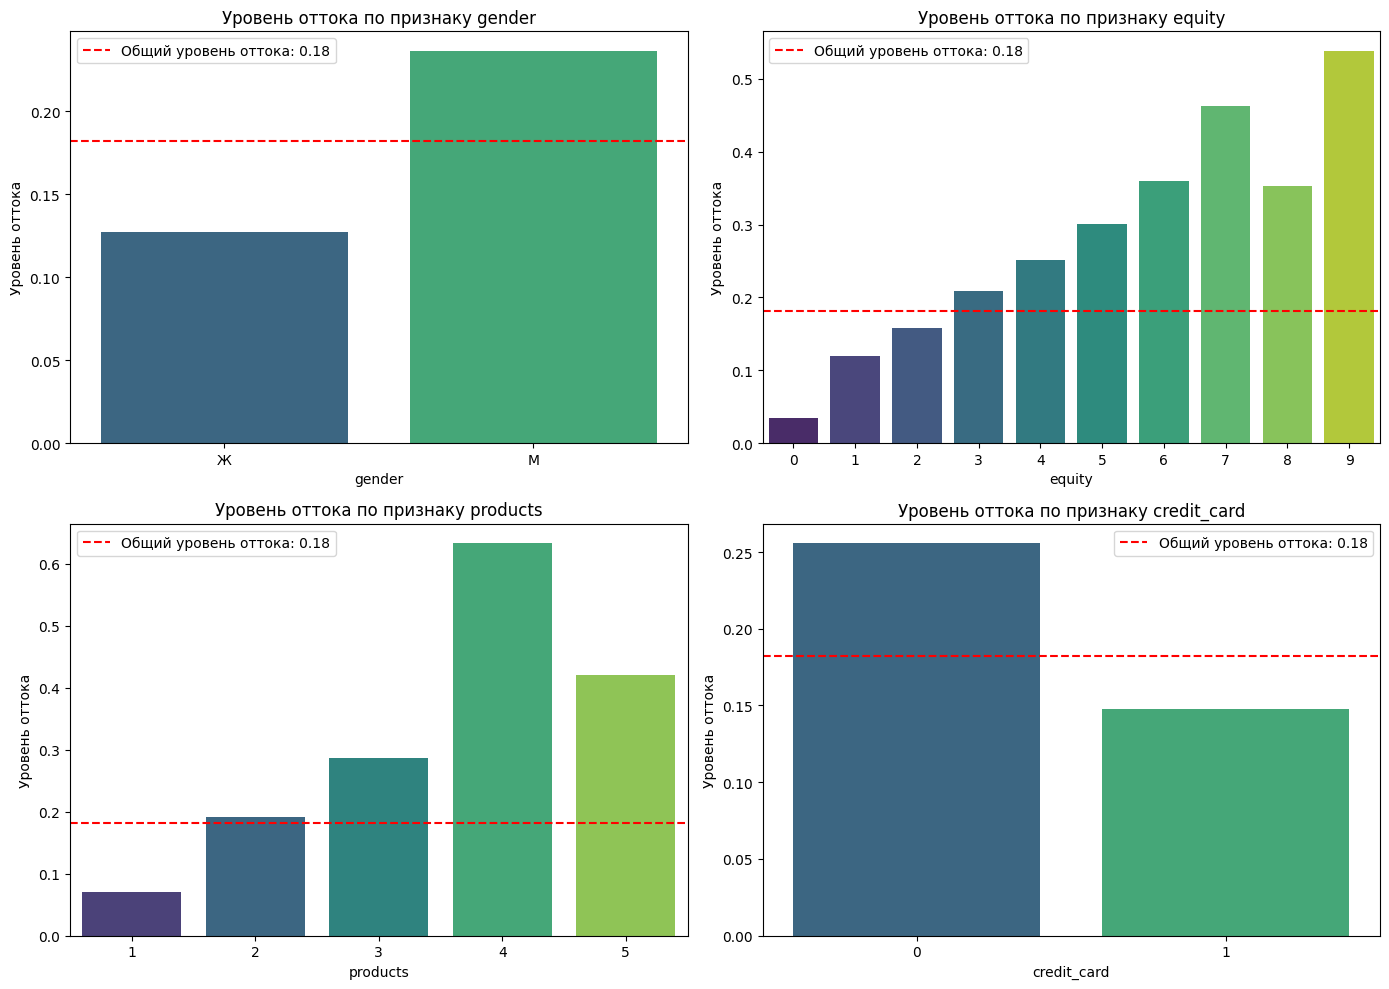

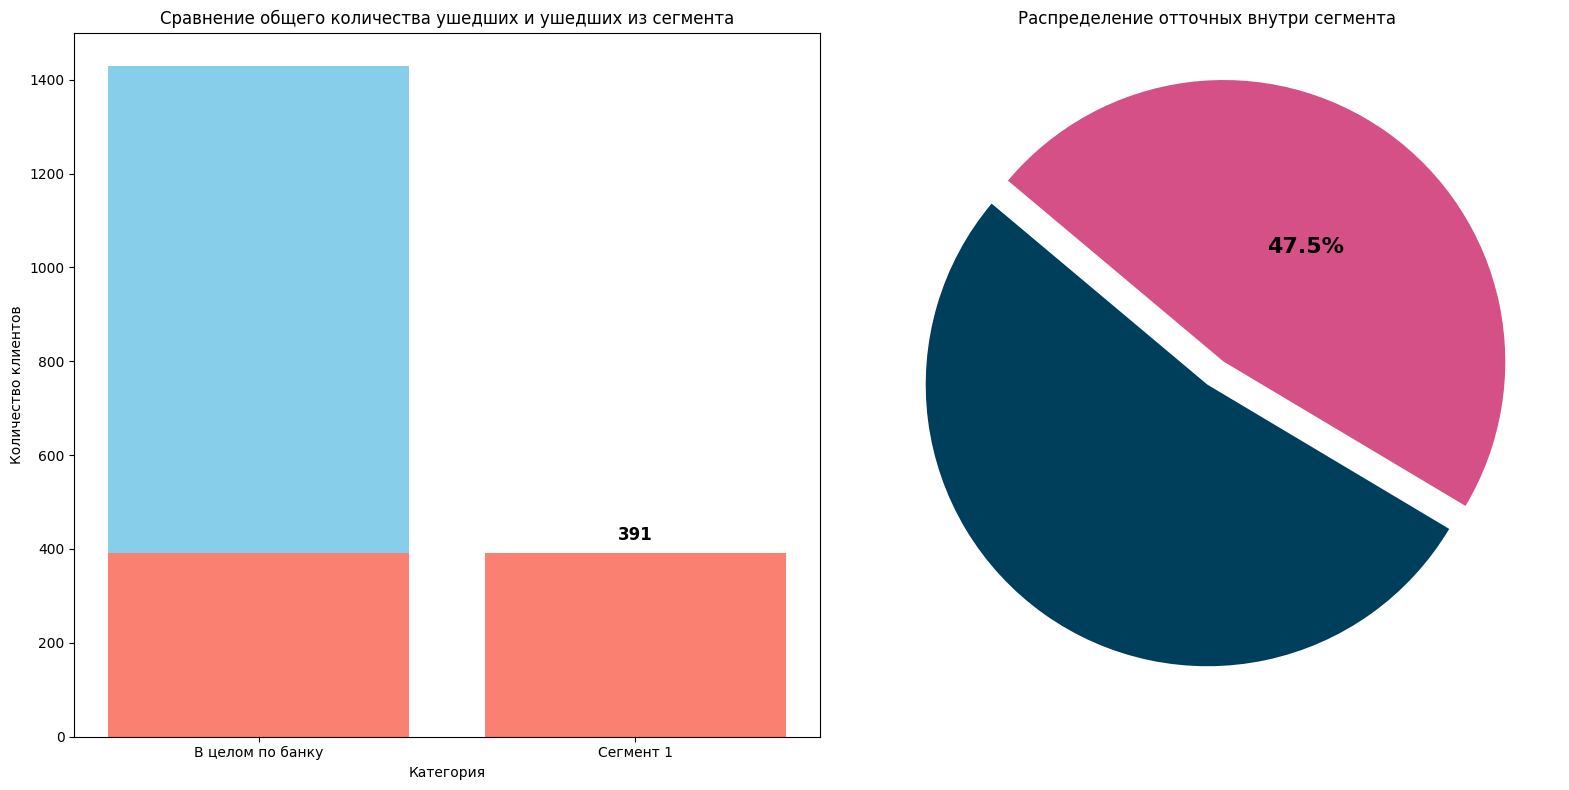

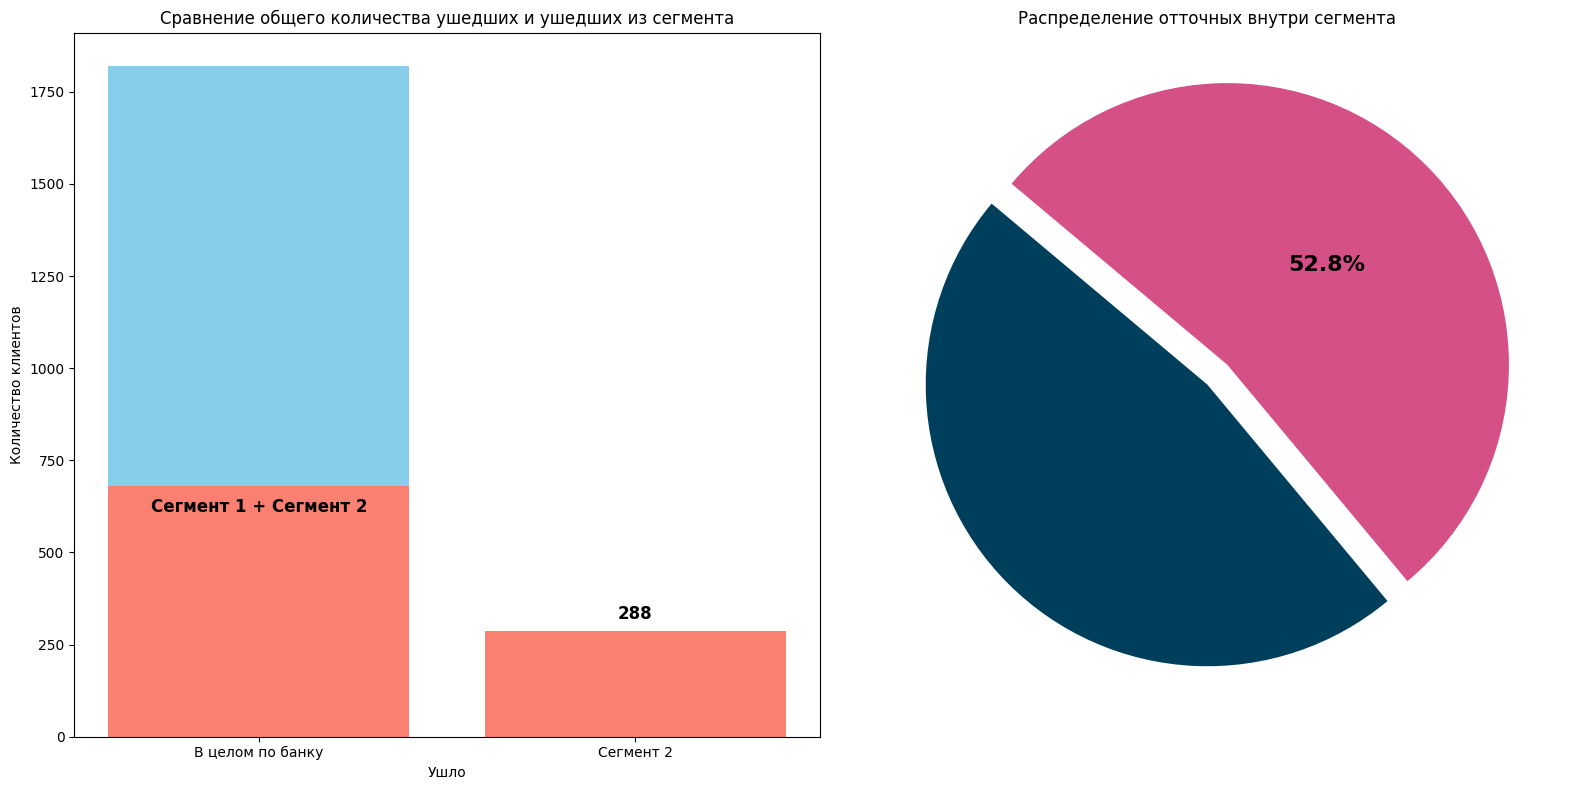

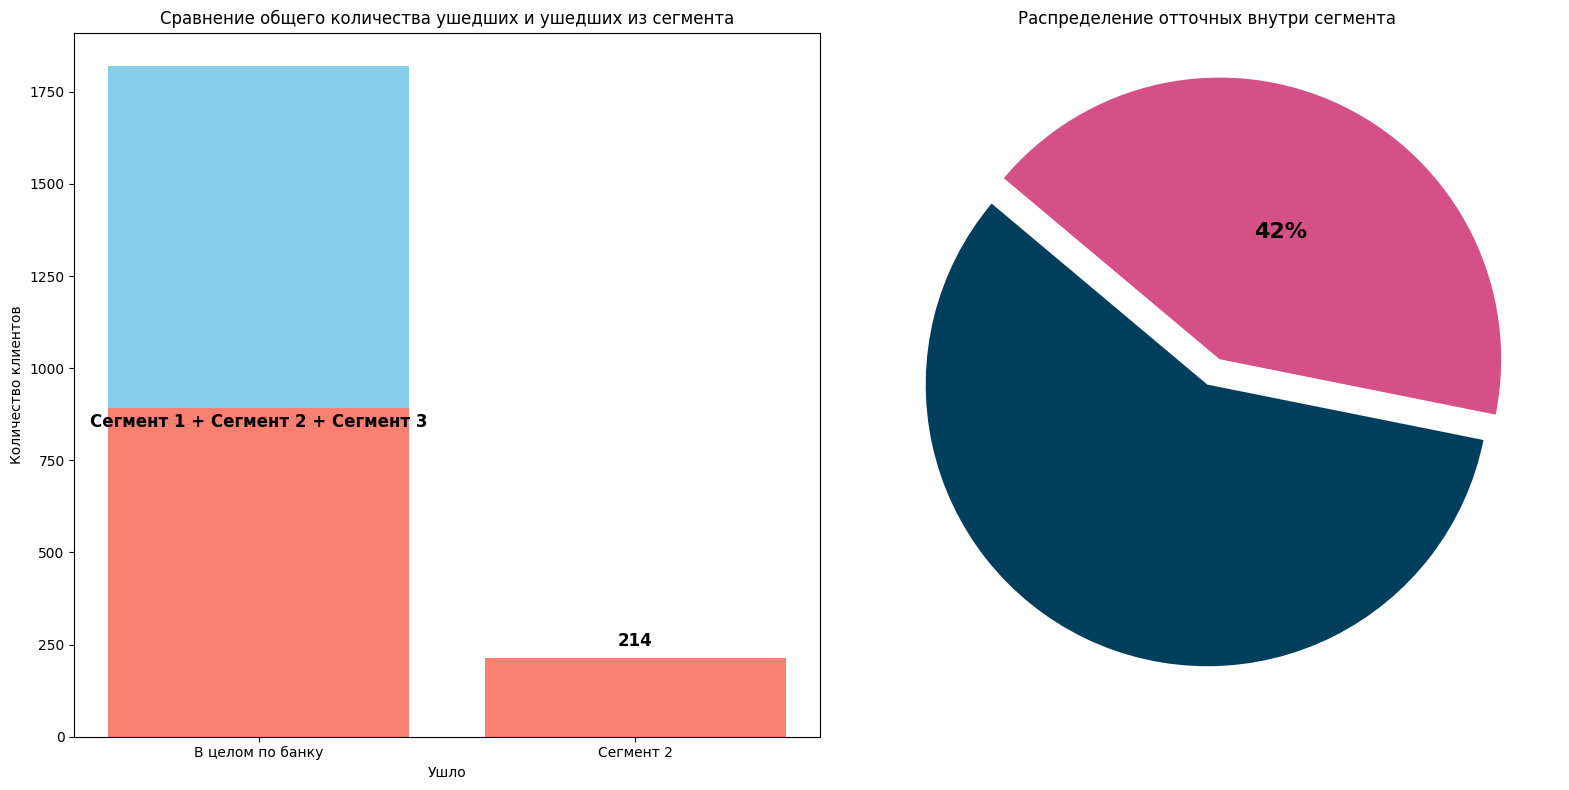

In [39]:
plt.figure(figsize=(12, 8))
sns.histplot(
    df['balance'], 
    bins=range(0, 3500000, 50000), 
    kde=False, 
    stat='density', 
    color='skyblue', 
    edgecolor='black')
sns.kdeplot(
    df['balance'], 
    color='darkred', 
    linestyle='-', 
    linewidth=3)
plt.title('Распределение значений баланса клиентов', fontsize=16, weight='bold')
plt.xlabel('Баланс', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.axvline(df['balance'].mean(), color='red', linestyle='--', linewidth=2, label='Средний баланс')
plt.axvline(df['balance'].median(), color='darkgreen', linestyle='--', linewidth=2, label='Медианный баланс')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 3500000)

products_counts = df['products'].value_counts().reset_index()
products_counts.columns = ['products', 'count']
products_counts = products_counts.sort_values(by='products')
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='products', 
    y='count', 
    data=products_counts, 
    palette='viridis')
plt.title('Распределение количества продуктов у клиентов', fontsize=16, weight='bold')
plt.xlabel('Количество продуктов', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10), 
        textcoords='offset points',
        fontsize=12, color='black', weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

total_churn = df['churn'].mean()
discrete_columns = ['gender', 'equity', 'products', 'credit_card'] 
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i, column in enumerate(discrete_columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    churn_rate = df.groupby(column)['churn'].mean()
    sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='viridis', ax=ax)
    ax.axhline(y=total_churn, color='red', linestyle='--', label=f'Общий уровень оттока: {total_churn:.2f}')
    ax.set_title(f'Уровень оттока по признаку {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Уровень оттока')
    ax.legend()
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
total_count = 1820
segment_count = 391
remaining_count = total_count - segment_count
axs[0].bar('В целом по банку', remaining_count, color='skyblue', label='Осталось в банке') 
axs[0].bar('В целом по банку', segment_count, color='salmon', label='Ушло из общего числа') 
axs[0].bar('Сегмент 1', segment_count, color='salmon', label='Ушедшие клиенты из сегмента 1') 
axs[0].set_title('Сравнение общего количества ушедших и ушедших из сегмента')
axs[0].set_ylabel('Количество клиентов')
axs[0].set_xlabel('Категория')
axs[0].text(1, segment_count + 20, '391', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
sizes = [52.55, 47.45]
colors = ['#003f5c', '#d45087']
explode = (0, 0.1) 
wedges, texts = axs[1].pie(sizes, explode=explode, colors=colors, labels=None,
                          autopct=None, pctdistance=0.85, startangle=140,
                          wedgeprops=dict(edgecolor='none')) 
angle = (wedges[1].theta2 + wedges[1].theta1) / 2.0
radius = 1  
x = radius * 0.6 * np.cos(np.deg2rad(angle))
y = radius * 0.6 * np.sin(np.deg2rad(angle))
axs[1].text(x, y, '47.5%', color='black', ha='center', va='center', fontsize=16, fontweight='bold')
axs[1].set_title('Распределение отточных внутри сегмента')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
lower_part = 679  
upper_part = total_count - lower_part
segment1_count = 288  
axs[0].bar('В целом по банку', lower_part, color='salmon', label='Осталось в банке') 
axs[0].bar('В целом по банку', upper_part, bottom=lower_part, color='skyblue', label='Ушло из общего числа') 
axs[0].bar('Сегмент 2', segment1_count, color='salmon', label='Ушло из сегмента 1')  
axs[0].set_title('Сравнение общего количества ушедших и ушедших из сегмента')
axs[0].set_ylabel('Количество клиентов')
axs[0].set_xlabel('Ушло')
axs[0].text(0, 600, 'Сегмент 1 + Сегмент 2', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
axs[0].text(1, segment1_count + 20, str(segment1_count), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
sizes = [47.16, 52.84]
colors = ['#003f5c', '#d45087']
explode = (0, 0.1)  
wedges, texts = axs[1].pie(sizes, explode=explode, colors=colors, labels=None,
                          autopct=None, pctdistance=0.85, startangle=140,
                          wedgeprops=dict(edgecolor='none'))  
angle = (wedges[1].theta2 + wedges[1].theta1) / 2.0
radius = 1  
x = radius * 0.6 * np.cos(np.deg2rad(angle))
y = radius * 0.6 * np.sin(np.deg2rad(angle))
axs[1].text(x, y, '52.8%', color='black', ha='center', va='center', fontsize=16, fontweight='bold')
axs[1].set_title('Распределение отточных внутри сегмента')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
total_count = 1820
segment_count = 391
remaining_count = total_count - segment_count
lower_part = 893  
upper_part = total_count - lower_part
segment1_count = 214  
axs[0].bar('В целом по банку', lower_part, color='salmon', label='Осталось в банке') 
axs[0].bar('В целом по банку', upper_part, bottom=lower_part, color='skyblue', label='Ушло из общего числа')  
axs[0].bar('Сегмент 2', segment1_count, color='salmon', label='Ушло из сегмента 1') 
axs[0].set_title('Сравнение общего количества ушедших и ушедших из сегмента')
axs[0].set_ylabel('Количество клиентов')
axs[0].set_xlabel('Ушло')
axs[0].text(0, 830, 'Сегмент 1 + Сегмент 2 + Сегмент 3', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
axs[0].text(1, segment1_count + 20, str(segment1_count), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
sizes = [57.96, 42.04]
colors = ['#003f5c', '#d45087']
explode = (0, 0.1)  
wedges, texts = axs[1].pie(sizes, explode=explode, colors=colors, labels=None,
                          autopct=None, pctdistance=0.85, startangle=140,
                          wedgeprops=dict(edgecolor='none'))  
angle = (wedges[1].theta2 + wedges[1].theta1) / 2.0
radius = 1  
x = radius * 0.6 * np.cos(np.deg2rad(angle))
y = radius * 0.6 * np.sin(np.deg2rad(angle))
axs[1].text(x, y, '42%', color='black', ha='center', va='center', fontsize=16, fontweight='bold')
axs[1].set_title('Распределение отточных внутри сегмента')
plt.tight_layout()

plt.show()